In [2]:
# Necessary Library Calls
import nibabel as nib
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from skimage.util import montage 
from skimage.transform import rotate
from sklearn.model_selection import train_test_split as ttt
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm import tqdm
from pylab import *
import gc
import torchmetrics 
import radiomics
from torchvision.utils import save_image
import matplotlib.image
import SimpleITK as sitk
import radiomics
from radiomics import featureextractor


In [28]:
# Global variable definition
IMAGE_PATH = 'data/MICCAI_BraTS_2019_Data_Training'
CSV_FILE='data/MICCAI_BraTS_2019_Data_Training/new.csv'
MODEL_PATH = 'log/23/'

# number of slices, meaning how many slices we are taking from one image file  
SLICE_NUM = 10
# Original Image Size
IMAGE_SIZE=240
# Image size after cropping
HEIGHT=128
WIDTH=144

# Batch size constant
BATCH_SIZE= 1
# input_channel corresponds to the number of different types of images used: 
# e.g: T1, T2, T1_flair, etc. 
# only using one type of images at the moment
INPUT_CHANNEL=2
EPOCH = 50
LEARNING_RATE = 0.001
SLICE_STARTS=torch.load('data/slice_starts.pt')
WEIGHT = torch.load('data/weight.pt')
device = torch.device('cuda')
LOAD_CURRENT = True
LOAD_BEST = False


In [29]:
"""

Data loader for easy data access. 

Output shape for get_item: X [slices, input_channels, W, H ]
                           y [slices, W, H, ]
Notes: the output channel for y has dimension of 1 and has value in range of (0,3).


"""


# Simple helper function for retriving images given the path
def get_image(image_path,image_cat,image_id,image_type):
    t1_data=nib.load(os.path.join(image_path,image_cat,image_id,'')+image_id+'_t1.nii.gz').get_fdata()
    t1ce_data=nib.load(os.path.join(image_path,image_cat,image_id,'')+image_id+'_t1ce.nii.gz').get_fdata()
    t2_data=nib.load(os.path.join(image_path,image_cat,image_id,'')+image_id+'_t2.nii.gz').get_fdata()
    seg_data=nib.load(image_path+'/'+image_cat+'/'+image_id+'/'+image_id+'_seg.nii.gz').get_fdata()
    flair_data=nib.load(os.path.join(image_path,image_cat,image_id,'')+image_id+'_flair.nii.gz').get_fdata()
    result={'t1':t1_data,'t1ce':t1ce_data,'t2':t2_data,'seg':seg_data,'flair':flair_data}
   
    return result[image_type]; 


class BraTS19Dataset(Dataset):
    def __init__(self, csv_f,i_path,i_type):
        self.source=pd.read_csv(csv_f)
        self.image_path=i_path
        self.type=i_type
        self.batch=BATCH_SIZE
    def __len__(self):
        return len(self.source)
     
    def __getitem__(self,idx):
        image_cat=self.source.iloc[idx,0]
        image_id=self.source.iloc[idx,1]
        starts=SLICE_STARTS[idx].int()
        age=self.source.iloc[idx,2]
        sur=self.source.iloc[idx,3]
        stu=self.source.iloc[idx,4]
        if sur<300: 
            cla = 0
        elif sur<450:
            cla=1
        else:
            cla =2
        #classification class 
        
        # get the image and its corresponding mask 
        img = np.zeros((INPUT_CHANNEL,IMAGE_SIZE,IMAGE_SIZE,155))
        
        for i in range(INPUT_CHANNEL):
            img[i]=get_image(self.image_path,image_cat,image_id,self.type[i])
        
     
        mask=get_image(self.image_path,image_cat,image_id,'seg')
        
        
        # change label 4 to 3 for easy index handling
        
        mask[mask==4]=3
        
        # initialize results arrays
        X=np.zeros((INPUT_CHANNEL,HEIGHT,WIDTH,SLICE_NUM))
        y=np.zeros((HEIGHT,WIDTH,SLICE_NUM))
        X = img[:,50:50+HEIGHT,55:55+WIDTH,starts-5:starts-5+SLICE_NUM]
        y = mask[50:50+HEIGHT,55:55+WIDTH,starts-5:starts-5+SLICE_NUM]
        X=torch.from_numpy(X)
        y=torch.from_numpy(y)
        
        
      
       
       
        y = y.long()
#        y = F.one_hot(y,num_classes=4)
        return (X.permute(3,0,1,2),y.permute(2,0,1),(age,sur,stu,cla))
    
def GetBraTS19Dataset(csv,ipath,itype,batch_size=1,shuffle=True,pin_memory=True):
    data = BraTS19Dataset(csv,ipath,itype)
    leng = [int(0.6* len(data)),int(0.2* len(data)),len(data) - int(0.6 * len(data))-int(0.2 * len(data))]
    train,eva,test=torch.utils.data.random_split(data,leng)
    train=DataLoader(train,batch_size=batch_size,shuffle=shuffle,pin_memory=pin_memory)
    eva=DataLoader(eva,batch_size=batch_size,shuffle=shuffle,pin_memory=pin_memory)
    test=DataLoader(eva,batch_size=batch_size,shuffle=shuffle,pin_memory=pin_memory)
    return train,eva,test

In [30]:
# Unet model
class Unet(nn.Module):

    def encoder_block(self,in_channels,out_channels,k=3,conv2d_pad1=(1,1),conv2d_pad2=(1,1)):
        block = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=k,padding=conv2d_pad1),
            
            nn.ReLU(inplace=True),
            nn.GroupNorm(32,out_channels),
            nn.Conv2d(out_channels,out_channels,kernel_size=k,padding=conv2d_pad2),
            
            nn.ReLU(inplace=True),
            nn.GroupNorm(32,out_channels),
        )
        return block
    
    # actual output channel size = output_channel/2
    def decoder_block(self,in_channels,out_channels,k=3,s=2,conv2d_pad1=(1,1),conv2d_pad2=(1,1),convtrans2d_pad=(0,0)):
        block = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=k,padding=conv2d_pad1),
            
            nn.ReLU(inplace=True),
            nn.GroupNorm(32,out_channels),
            nn.Conv2d(out_channels,out_channels,kernel_size=k,padding=conv2d_pad2),
            
            nn.ReLU(inplace=True),
            nn.GroupNorm(32,out_channels),
            nn.ConvTranspose2d(out_channels,int(out_channels/2),kernel_size=2,stride=s,padding=convtrans2d_pad),
        )
        return block
    
    def bottle_neck(self,in_channels,out_channels,k=3):
        block = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=k,stride=1,padding=1),
            
            nn.ReLU(inplace=True),
            nn.GroupNorm(32,out_channels),
            nn.Conv2d(out_channels,out_channels,kernel_size=k,stride=1,padding=1),
            
            nn.ReLU(inplace=True),
            nn.GroupNorm(32,out_channels),
            nn.Dropout(p=0.5),
            nn.ConvTranspose2d(out_channels,in_channels,kernel_size=2,stride=2,padding=(0,0),output_padding=(0,0)),
        )
        return block
    
        
    def final_block(self,in_channels,out_channels,k):
        
        block = nn.Sequential(
            nn.Conv2d(in_channels,int(in_channels/2),kernel_size=k,padding=(1,1)),
            
            nn.ReLU(inplace=True),
            nn.GroupNorm(16,int(in_channels/2)),
            nn.Conv2d(int(in_channels/2),out_channels,kernel_size=k,padding=(1,1)),
            
            nn.ReLU(inplace=True),
            nn.GroupNorm(4,out_channels),
            nn.Conv2d(out_channels,out_channels,kernel_size=1,stride=1),
            nn.Softmax(dim=1),
            
        )
        
        return block
    
    def __init__(self, in_channel, out_channel):
        super(Unet, self).__init__()
        self.en1=self.encoder_block(in_channel,32)
        self.max1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.en2=self.encoder_block(32,64)
        self.max2 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.en3=self.encoder_block(64,128)
        self.max3 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.en4=self.encoder_block(128,256)
        self.max4 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.bn=self.bottle_neck(256,512)
        self.dc4=self.decoder_block(512,256)
        self.dc3=self.decoder_block(256,128)
        self.dc2=self.decoder_block(128,64)
        self.final=self.final_block(64,out_channel,k=3)
   
    def forward(self,x):
        encoder_block1=self.en1(x)
        mp1 = self.max1(encoder_block1)
        encoder_block2=self.en2(mp1)
        mp2 = self.max2(encoder_block2)
        encoder_block3=self.en3(mp2)
        mp3 = self.max3(encoder_block3)
        encoder_block4=self.en4(mp3)
        mp4 = self.max4(encoder_block4)
        bottleneck_block1 =self.bn(mp4)
        
        cat_block4= torch.cat((bottleneck_block1,encoder_block4),1)
        decoder_block4=self.dc4(cat_block4)
        
        cat_block3= torch.cat((decoder_block4,encoder_block3),1)
        decoder_block3=self.dc3(cat_block3)
        
        cat_block2= torch.cat((decoder_block3,encoder_block2),1)
        decoder_block2=self.dc2(cat_block2)
        
        cat_block1= torch.cat((decoder_block2,encoder_block1),1)
        
        result=self.final(cat_block1)
        
        return result

In [31]:
class DiceScore(nn.Module):

    def __init__(self):
        super(DiceScore, self).__init__()
        
    def forward(self, y_pred, y_true):
        dice = torchmetrics.Dice(average = 'micro').to(device)
        macdice = torchmetrics.Dice(num_classes=4,average = 'macro').to(device)
        assert y_pred.size() == y_true.size()
        y_pred1 = F.one_hot(torch.argmax(y_pred,dim=3),num_classes=4)
      
        yp0 = y_pred1[:,:,:,0].contiguous().view(-1)
        yt0 = y_true[:,:,:,0].contiguous().view(-1)
        t0 = dice(yp0,yt0)
        
        yp1 = y_pred1[:,:,:,1].contiguous().view(-1)
        yt1 = y_true[:,:,:,1].contiguous().view(-1)
        t1 = dice(yp1,yt1)
        
        yp2 = y_pred1[:,:,:,2].contiguous().view(-1)
        yt2 = y_true[:,:,:,2].contiguous().view(-1)
        t2 = dice(yp2,yt2)
        
    
        yp3 = y_pred1[:,:,:,3].contiguous().view(-1)
        yt3 = y_true[:,:,:,3].contiguous().view(-1)
        t3 = dice(yp3,yt3)


        return macdice(y_pred1,y_true),t0,t1,t2,t3


"""

""" 
        
        
        
        
        

'\n\n'

In [32]:
class DiceLoss(nn.Module):

    def __init__(self):
        super(DiceLoss, self).__init__()
        
    def forward(self, y_pred, y_true):
        total_loss=0.0
        assert y_pred.size() == y_true.size()
        for i in range(4):
            preds =torch.flatten(y_pred[:,:,:,i])
         
            target =torch.flatten(y_true[:,:,:,i])
            intersection = torch.sum((preds * target))

            dsc = (2. * intersection + 1) / (torch.sum(preds) + torch.sum(target) + 1)
            total_loss+=(1-dsc)
        
        
       
        return total_loss/4

In [33]:
# Train function
def training(dataset, model, opt,  dev, batch_size, lr):
    print('Training in session: ')
    iou=torchmetrics.JaccardIndex('multiclass',num_classes=4,validate_args=False).to(device)
    dic = DiceScore().to(device)
    IoU=[]
    md=[]
    d0=[]
    d1=[]
    d2=[]
    d3=[]
    epoch_loss=0.0
    dataset=tqdm(dataset)
    for index, batch in enumerate(dataset):
        
        # reshape the data and load the data to gpu
        x, y,other= batch 
        a,b,c,d,e=x.shape
        x=x.reshape(a*b,c,d,e)
        x=x.float()

        a,b,c,d=y.shape
        y=y.reshape(a*b,c,d)
        
        x,y=x.to(device),y.to(device)
       
        
      
        
        
        
        loss_fn = DiceLoss().to(device)
       
        # training model
        res = model(x)
        res=res.to(device)
        loss = loss_fn(res.permute(0,2,3,1).to(device),F.one_hot(y,num_classes=4).to(device)).to(device)
        
        opt.zero_grad()
        
        loss.backward()
        
        opt.step()
        
        #torch.nn.utils.clip_grad_norm_(model.parameters(), gc)
        
        
        
        # Loss 
        print("Batch_id: ", index,"Training loss: ", loss.item())
        epoch_loss+=loss.item()
        
        
        
        
        #IoU
        bac = iou(torch.argmax(res,dim = 1).to(device),y.to(device)).to(device)
        print("Batch_id: ", index,"Training IoU: ", bac)
        IoU.append(bac)
        
        
        
        # Dice Score
        
        t,t0,t1,t2,t3=dic(res.permute(0,2,3,1).to(device),F.one_hot(y,num_classes=4).to(device))
        
        
            
        print("Batch_id: ", index,"Training Mean Dice Score: ", t)
        md.append(t)
            
        print("Batch_id: ", index,"Training Non-tumor Dice Score: ", t0)
        d0.append(t0)
            
        print("Batch_id: ", index,"Training NCR/NET Dice Score: ", t1)
        d1.append(t1)
            
        print("Batch_id: ", index,"Training ED Dice Score: ", t2)
        d2.append(t2)
            
        print("Batch_id: ", index,"Training ET Dice Score: ", t3)
        d3.append(t3)

        
            
    IoU=torch.tensor(IoU)
    md = torch.tensor(md)
    d0=torch.tensor(d0)
    d1=torch.tensor(d1)
    d2=torch.tensor(d2)
    d3=torch.tensor(d3)
    return torch.mean(IoU),epoch_loss,torch.mean(md),torch.mean(d0),torch.mean(d1),torch.mean(d2),torch.mean(d3)
        
        
        
        





       
        
        
        
#        IoU.append(iou(res,y.float()).to(torch.device('cpu')))
    
    
   

In [34]:
# Evaluation function
def evaluation(dataset, model):
    print('Evaluation in session: ')
    iou=torchmetrics.JaccardIndex('multiclass',num_classes=4,validate_args=False).to(device)
    dic = DiceScore().to(device)
    IoU=[]
    md=[]
    d0=[]
    d1=[]
    d2=[]
    d3=[]
    epoch_loss=0.0
    dataset=tqdm(dataset)
    model.eval()
    with torch.no_grad():
        
        for index, batch in enumerate(dataset):
        
            # reshape the data and load the data to gpu
            x, y,other= batch 
            a,b,c,d,e=x.shape
            x=x.reshape(a*b,c,d,e)
            x=x.float()
        
            a,b,c,d=y.shape
            y=y.reshape(a*b,c,d)
        
            x,y=x.to(device),y.to(device)
       
        
        
        
        
        
            loss_fn = DiceLoss().to(device)
       
            #eval
            res = model(x)
            res=res.to(device)
            loss = loss_fn(res.permute(0,2,3,1).to(device),F.one_hot(y,num_classes=4).to(device)).to(device)
        
        
        
            # Loss
            print("Batch_id: ", index,"Eval loss: ", loss.item())
            epoch_loss+=loss.item()
            
            
            # IoU

            bac = iou(torch.argmax(res,dim = 1).to(device),y.to(device)).to(device)
            print("Batch_id: ", index,"Eval IoU: ", bac)
            IoU.append(bac)
            
            # Dice Score
            t,t0,t1,t2,t3=dic(res.permute(0,2,3,1).to(device),F.one_hot(y,num_classes=4).to(device))
            
            print("Batch_id: ", index,"Eval Mean Dice Score: ", t)
            md.append(t)
            
            print("Batch_id: ", index,"Eval Non-tumor Dice Score: ", t0)
            d0.append(t0)
            
            print("Batch_id: ", index,"Eval NCR/NET Dice Score: ", t1)
            d1.append(t1)
            
            print("Batch_id: ", index,"Eval ED Dice Score: ", t2)
            d2.append(t2)
            
            print("Batch_id: ", index,"Eval ET Dice Score: ", t3)
            d3.append(t3)
            if index%10==0:
                
                img1=np.zeros((HEIGHT,WIDTH))
                img1=torch.tensor(img1)
                img1[:,:]=res.argmax(dim=1)[5,:,:]
                img1[img1==3]=4
                img2=np.zeros((HEIGHT,WIDTH))
                img2=torch.tensor(img2)
                img2[:,:]=y[5,:,:]
                img2[img2==3]=4
                figure()
                imshow(img1)
                show()
                figure()
                imshow(img2)
                show()
            
            
            

            
    IoU=torch.tensor(IoU)
    md = torch.tensor(md)
    d0=torch.tensor(d0)
    d1=torch.tensor(d1)
    d2=torch.tensor(d2)
    d3=torch.tensor(d3)
    return torch.mean(IoU),epoch_loss,torch.mean(md),torch.mean(d0),torch.mean(d1),torch.mean(d2),torch.mean(d3)
    
    
    

In [35]:
# Load Best Model
def test(dataset):
    print('test in session: ') 
    checkpoint = torch.load(MODEL_PATH+'#23-BEST')
    model = Unet(in_channel=INPUT_CHANNEL,out_channel=4).to(device)
    opt = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    model.load_state_dict(checkpoint['model_state_dict'])
    opt.load_state_dict(checkpoint['optim_state_dict'])
    epoch = checkpoint['epoch']
    Avg_dice = checkpoint['Eval Dice Scores']
    non = checkpoint['Eval Non-tumor Dice Scores']
    ncr = checkpoint['Eval NCR/NET Dice Scores']
    ed = checkpoint['Eval ED Dice Scores']
    et = checkpoint['Eval ET Dice Scores']
    
    print('Model loaded!','Epoch = ', epoch, 'Mean eval dice scores is: ',Avg_dice)
    print('Dice Scorese Per class: ')
    print('Non-Tumor: ', non)
    print('NCR/NET: ', ncr)
    print('ED: ', ed)
    print('ET: ',et)
    iou=torchmetrics.JaccardIndex('multiclass',num_classes=4,validate_args=False).to(device)
    dic = DiceScore().to(device)
    IoU=[]
    md=[]
    d0=[]
    d1=[]
    d2=[]
    d3=[]
    epoch_loss=0.0
    dataset=tqdm(dataset)
    model.eval()
    with torch.no_grad():
        
        for index, batch in enumerate(dataset):
        
            # reshape the data and load the data to gpu
            x, y,other= batch 
            a,b,c,d,e=x.shape
            x=x.reshape(a*b,c,d,e)
            x=x.float()
        
            a,b,c,d=y.shape
            y=y.reshape(a*b,c,d)
        
            x,y=x.to(device),y.to(device)
       
        
    

    
        
        
        
        
            loss_fn = DiceLoss().to(device)
       
            #test
            res = model(x)
            res=res.to(device)
            loss = loss_fn(res.permute(0,2,3,1).to(device),F.one_hot(y,num_classes=4).to(device)).to(device)
        
        
        
            # Loss
            print("Batch_id: ", index,"Test loss: ", loss.item())
            epoch_loss+=loss.item()
            
            
            # IoU

            bac = iou(torch.argmax(res,dim = 1).to(device),y.to(device)).to(device)
            print("Batch_id: ", index,"Test IoU: ", bac)
            IoU.append(bac)
            
            
            # Dice Score
            t,t0,t1,t2,t3=dic(res.permute(0,2,3,1).to(device),F.one_hot(y,num_classes=4).to(device))
            
            print("Batch_id: ", index,"Test Mean Dice Score: ", t)
            md.append(t)
            
            print("Batch_id: ", index,"Test Non-tumor Dice Score: ", t0)
            d0.append(t0)
            
            print("Batch_id: ", index,"Test NCR/NET Dice Score: ", t1)
            d1.append(t1)
            
            print("Batch_id: ", index,"Test ED Dice Score: ", t2)
            d2.append(t2)
            
            print("Batch_id: ", index,"Test ET Dice Score: ", t3)
            d3.append(t3)

            img1=np.zeros((HEIGHT,WIDTH))
            img1=torch.tensor(img1)
            img1[:,:]=res.argmax(dim=1)[0,:,:]
            img1[img1==3]=4
            img2=np.zeros((HEIGHT,WIDTH))
            img2=torch.tensor(img2)
            img2[:,:]=y[0,:,:]
            img2[img2==3]=4
            figure()
            imshow(img1)
            show()
            figure()
            imshow(img2)
            show()
            
    IoU=torch.tensor(IoU)
    md = torch.tensor(md)
    d0=torch.tensor(d0)
    d1=torch.tensor(d1)
    d2=torch.tensor(d2)
    d3=torch.tensor(d3)
    print('Avg IoU: ',torch.mean(IoU))
    print('Avg Loss: ',epoch_loss/(36))
    print('Avg Dice Scores: ', torch.mean(md))
    print('Non-Tumor Dice Scores: ',torch.mean(d0))
    print('NCR/NET Dice Scores: ',torch.mean(d1))
    print('ED Dice Scores: ',torch.mean(d2))
    print('ET Dice Scores: ', torch.mean(d3))
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    

In [36]:
# main

def main(BEST_EVAL):
    if LOAD_CURRENT:
        train_data = torch.load(MODEL_PATH+'trdata.pth')
        eval_data = torch.load(MODEL_PATH+'edata.pth')
        test_data = torch.load(MODEL_PATH+'tdata.pth')
    else:
        train_data,eval_data,test_data = GetBraTS19Dataset(CSV_FILE,IMAGE_PATH,['t1ce','flair'],batch_size=BATCH_SIZE)
        torch.save(train_data, MODEL_PATH+'trdata.pth')
        torch.save(eval_data, MODEL_PATH+'edata.pth')
        torch.save(test_data,MODEL_PATH+'tdata.pth')
    
    print('Data Loaded!')
    
    
    
    
    
    model = Unet(in_channel=INPUT_CHANNEL,out_channel=4).to(device)
    opt = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    sc = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,patience=5,factor = 0.5,threshold=0.1,mode = 'max',verbose = True)
    if LOAD_CURRENT:
        checkpoint = torch.load(MODEL_PATH+'#23-current')
        model.load_state_dict(checkpoint['model_state_dict'])
        opt.load_state_dict(checkpoint['optim_state_dict'])
        sc.load_state_dict(checkpoint['sche'])
        index =torch.load(MODEL_PATH+'index.pt')
        loss_value=torch.load(MODEL_PATH+'tloss.pt')
        accuracy=torch.load(MODEL_PATH+'tac.pt')
        eval_loss=torch.load(MODEL_PATH+'eloss.pt')
        eval_accuracy=torch.load(MODEL_PATH+'eacc.pt')
        mean_dice=torch.load(MODEL_PATH+'md.pt')
        d0=torch.load(MODEL_PATH+'d0.pt')
        d1=torch.load(MODEL_PATH+'d1.pt')
        d2=torch.load(MODEL_PATH+'d2.pt')
        d3=torch.load(MODEL_PATH+'d3.pt')
        e_mean_dice=torch.load(MODEL_PATH+'emd.pt')
        ed0=torch.load(MODEL_PATH+'ed0.pt')
        ed1=torch.load(MODEL_PATH+'ed1.pt')
        ed2=torch.load(MODEL_PATH+'ed2.pt')
        ed3=torch.load(MODEL_PATH+'ed3.pt')     
        ep = torch.load(MODEL_PATH+'ep.pt')
        
    else:
        index =[]
        loss_value=[]
        accuracy=[]
        eval_loss=[]
        eval_accuracy=[]
        mean_dice=[]
        d0=[]
        d1=[]
        d2=[]
        d3=[]
        e_mean_dice=[]
        ed0=[]
        ed1=[]
        ed2=[]
        ed3=[]
        ep = 0 
    
    
    for i in range (ep,EPOCH):
        print(f'Epoch: {i}')
        
        acc, loss_val,md,di0,di1,di2,di3=training(train_data,model.train(),opt, device,BATCH_SIZE,LEARNING_RATE)
        
        eacc,eloss_val,emd,edi0,edi1,edi2,edi3=evaluation(eval_data,model.eval())
        sc.step(eloss_val)
        
        loss_value.append(loss_val/len(train_data.sampler))
        accuracy.append(acc)
        mean_dice.append(md)
        d0.append(di0)
        d1.append(di1)
        d2.append(di2)
        d3.append(di3)
        
        eval_loss.append(eloss_val/len(eval_data.sampler))
        eval_accuracy.append(eacc)
        e_mean_dice.append(emd)
        ed0.append(edi0)
        ed1.append(edi1)
        ed2.append(edi2)
        ed3.append(edi3)
        
        index.append(i)
        ep=ep+1
        
        torch.save(index,MODEL_PATH+'index.pt')
        torch.save(loss_value,MODEL_PATH+'tloss.pt')
        torch.save(accuracy,MODEL_PATH+'tac.pt')
        torch.save(eval_loss,MODEL_PATH+'eloss.pt')
        torch.save(eval_accuracy,MODEL_PATH+'eacc.pt')
        torch.save(mean_dice,MODEL_PATH+'md.pt')
        torch.save(d0,MODEL_PATH+'d0.pt')
        torch.save(d1,MODEL_PATH+'d1.pt')
        torch.save(d2,MODEL_PATH+'d2.pt')
        torch.save(d3,MODEL_PATH+'d3.pt')
        torch.save(e_mean_dice,MODEL_PATH+'emd.pt')
        torch.save(ed0,MODEL_PATH+'ed0.pt')
        torch.save(ed1,MODEL_PATH+'ed1.pt')
        torch.save(ed2,MODEL_PATH+'ed2.pt')
        torch.save(ed3,MODEL_PATH+'ed3.pt')     
        torch.save(ep,MODEL_PATH+'ep.pt')
        
        
        print('Epoch ',i,'Training loss: ',loss_val/len(train_data.sampler))
        print('Epoch ',i,'Evaluation loss: ',eloss_val/len(eval_data.sampler))
        
        print('Epoch ',i,'Training accuracy : ',acc)
        print('Epoch ',i,'Evaluation accuracy : ',eacc)
        
        print('Epoch ',i,'Training Mean Dice Score: ',md)
        print('Epoch ',i,'Eval Mean Dice Score: ',emd)
        
        print('Epoch ',i,'Training Non-tumor Dice Score: ',di0)
        print('Epoch ',i,'Eval Non-tumor Dice Score: ',edi0)
       
        print('Epoch ',i,'Training NCR/NET Dice Score: ',di1)
        print('Epoch ',i,'Eval NCR/NET Dice Score: ',edi1)
        
        print('Epoch ',i,'Training ED Dice Score: ',di2)
        print('Epoch ',i,'Eval ED Dice Score: ',edi2)
        
        print('Epoch ',i,'Training ET Dice Score: ',di3)
        print('Epoch ',i,'Eval ET Dice Score: ',edi3)
        torch.save({
            'model_state_dict': model.state_dict(),
            'optim_state_dict': opt.state_dict(),
            'epoch': i,
            'sche':sc.state_dict(),
            'Training loss_values': loss_val/len(train_data.sampler),
            'Training accuracy':acc,
            'Eval loss_values': eloss_val/len(eval_data.sampler),
            'Eval IoU':eacc,
            'Training Dice Scores':md,
            'Eval Dice Scores': emd,
            'Training Non-tumor Dice Scores':di0,
            'Eval Non-tumor Dice Scores':edi0,   
            'Training NCR/NET Dice Scores': di1,
            'Eval NCR/NET Dice Scores': edi1,   
            'Training ED Dice Scores': di2,
            'Eval ED Dice Scores': edi2,    
            'Training ET Dice Scores': di3,
            'Eval ET Dice Scores': edi3,    
            }, MODEL_PATH+'#23-current')
        print('Epoch completed and model successfully saved')
        if BEST_EVAL < eacc :
            torch.save({
            'model_state_dict': model.state_dict(),
            'optim_state_dict': opt.state_dict(),
            'epoch': i,
            'sche':sc.state_dict(),
            'Training loss_values': loss_val/len(train_data.sampler),
            'Training accuracy':acc,
            'Eval loss_values': eloss_val/len(eval_data.sampler),
            'Eval IoU':eacc,
            'Training Dice Scores':md,
            'Eval Dice Scores': emd,
            'Training Non-tumor Dice Scores':di0,
            'Eval Non-tumor Dice Scores':edi0,   
            'Training NCR/NET Dice Scores': di1,
            'Eval NCR/NET Dice Scores': edi1,   
            'Training ED Dice Scores': di2,
            'Eval ED Dice Scores': edi2,    
            'Training ET Dice Scores': di3,
            'Eval ET Dice Scores': edi3,    
            }, MODEL_PATH+'#23-BEST')
            print("Best Model saved!")
            BEST_EVAL = eacc
        gc.collect()
        torch.cuda.empty_cache()
        if eacc > 0.85:
            break
        
    plt.plot(index, loss_value, label ="Training ")
    plt.plot(index,eval_loss, label = "Validation")
    plt.title("Training and Validation Loss Curve: (Sample_size={}, lr={})".format(BATCH_SIZE*SLICE_NUM ,LEARNING_RATE))
    plt.xlabel("Epoch:")
    plt.ylabel("Average Loss ")
    plt.legend()
    plt.savefig(MODEL_PATH+ 'Training and eval Loss plot.png')
    plt.show()
    
    
    plt.plot(index, accuracy,label ="Training ")
    plt.plot(index, eval_accuracy,label ="Validation ")
    plt.title("Training and Validation IoU Scores (batch_size={}, lr={})".format(BATCH_SIZE*SLICE_NUM, LEARNING_RATE))
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (Mean IoU Scores)")
    plt.legend()
    plt.savefig(MODEL_PATH+ 'Training and eval Accuracy plot.png')
    plt.show()
    
    plt.plot(index, mean_dice, label ="Training ")
    plt.plot(index,e_mean_dice, label = "Validation")
    plt.title("Training and Validation Mean Dice Scores: (Sample_size={}, lr={})".format(BATCH_SIZE*SLICE_NUM ,LEARNING_RATE))
    plt.xlabel("Epoch:")
    plt.ylabel("Mean Dice Scores: ")
    plt.legend()
    plt.savefig(MODEL_PATH+ 'Training and eval avg dice plot.png')
    plt.show()
    
    plt.plot(index, d0, label ="Non-Tumor ")
    plt.plot(index,d1, label = "NCT/NET")
    plt.plot(index, d2, label ="ED ")
    plt.plot(index,d3, label = "ET")
    plt.title("Training Dice Scores per class: (Sample_size={}, lr={})".format(BATCH_SIZE*SLICE_NUM ,LEARNING_RATE))
    plt.xlabel("Epoch:")
    plt.ylabel("Mean Dice Scores: ")
    plt.legend()
    plt.savefig(MODEL_PATH+ 'Training dice per class plot.png')
    plt.show()
    
    plt.plot(index, ed0, label ="Non-Tumor ")
    plt.plot(index,ed1, label = "NCT/NET")
    plt.plot(index, ed2, label ="ED ")
    plt.plot(index,ed3, label = "ET")
    plt.title("Validation Dice Scores per class: (Sample_size={}, lr={})".format(BATCH_SIZE*SLICE_NUM ,LEARNING_RATE))
    plt.xlabel("Epoch:")
    plt.ylabel("Mean Dice Scores: ")
    plt.legend()
    plt.savefig(MODEL_PATH+ 'Eval dice per class plot.png')
    plt.show()
    test(test_data.dataset)

In [37]:
gc.collect()
torch.cuda.empty_cache()

Data Loaded!


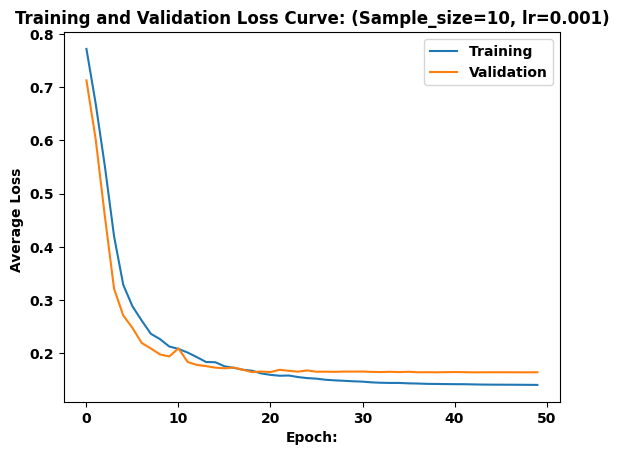

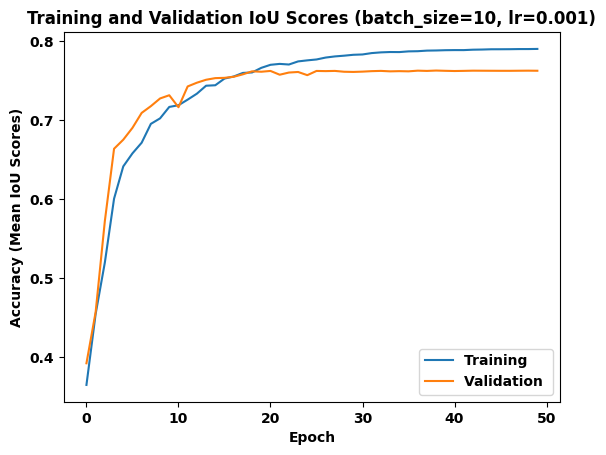

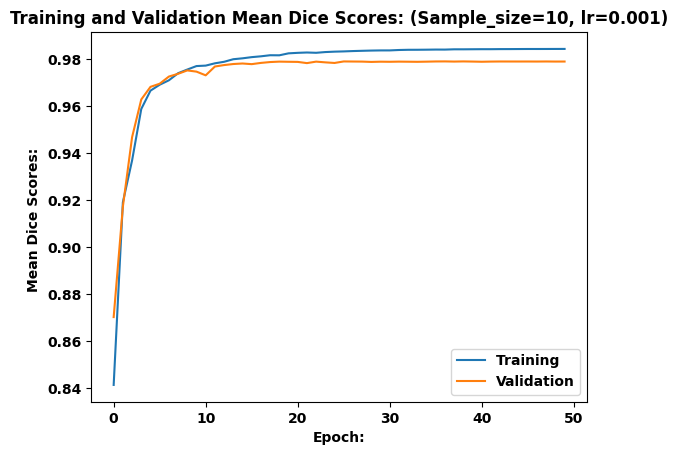

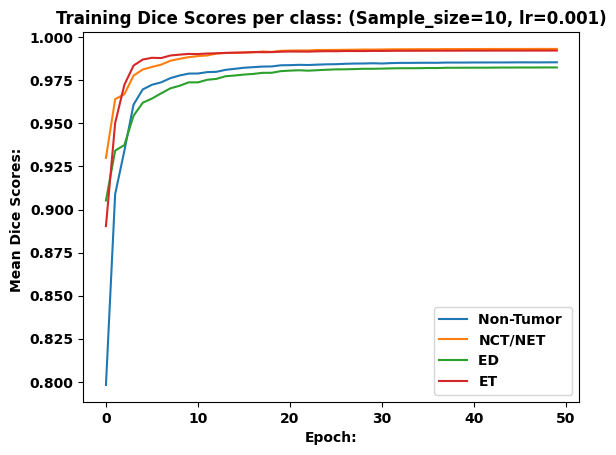

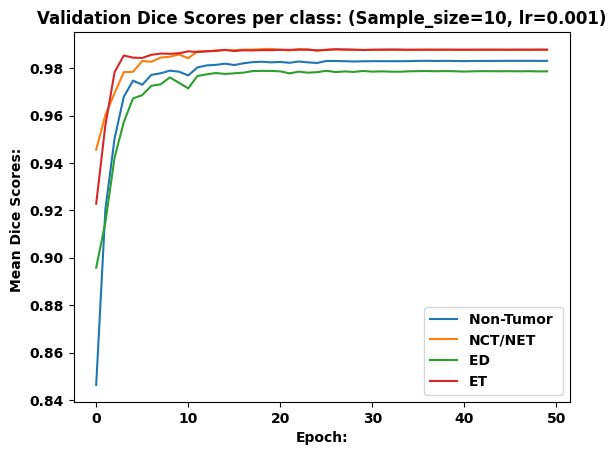

test in session: 
Model loaded! Epoch =  38 Mean eval dice scores is:  tensor(0.9792)
Dice Scorese Per class: 
Non-Tumor:  tensor(0.9831)
NCR/NET:  tensor(0.9878)
ED:  tensor(0.9788)
ET:  tensor(0.9878)


  0%|          | 0/36 [00:00<?, ?it/s]

Batch_id:  0 Test loss:  0.09386652708053589
Batch_id:  0 Test IoU:  tensor(0.8365, device='cuda:0')
Batch_id:  0 Test Mean Dice Score:  tensor(0.9901, device='cuda:0')
Batch_id:  0 Test Non-tumor Dice Score:  tensor(0.9914, device='cuda:0')
Batch_id:  0 Test NCR/NET Dice Score:  tensor(0.9950, device='cuda:0')
Batch_id:  0 Test ED Dice Score:  tensor(0.9912, device='cuda:0')
Batch_id:  0 Test ET Dice Score:  tensor(0.9926, device='cuda:0')


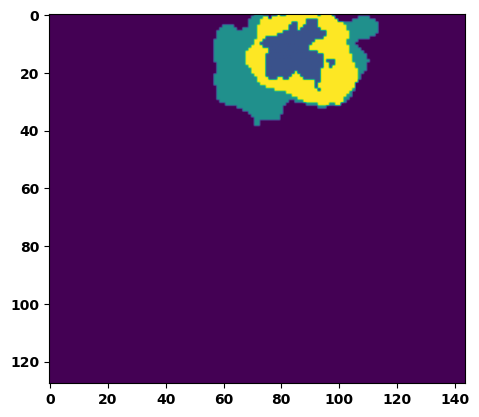

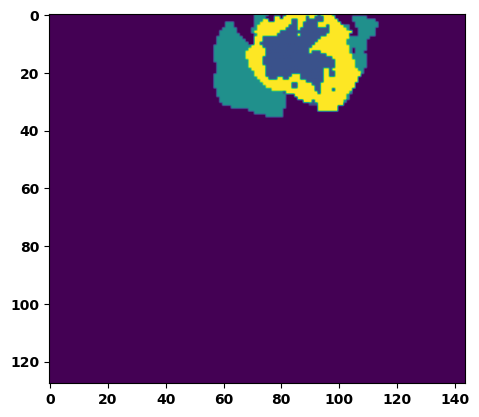

  3%|▎         | 1/36 [00:01<00:50,  1.44s/it]

Batch_id:  1 Test loss:  0.1459609717130661
Batch_id:  1 Test IoU:  tensor(0.7769, device='cuda:0')
Batch_id:  1 Test Mean Dice Score:  tensor(0.9823, device='cuda:0')
Batch_id:  1 Test Non-tumor Dice Score:  tensor(0.9804, device='cuda:0')
Batch_id:  1 Test NCR/NET Dice Score:  tensor(0.9954, device='cuda:0')
Batch_id:  1 Test ED Dice Score:  tensor(0.9765, device='cuda:0')
Batch_id:  1 Test ET Dice Score:  tensor(0.9946, device='cuda:0')


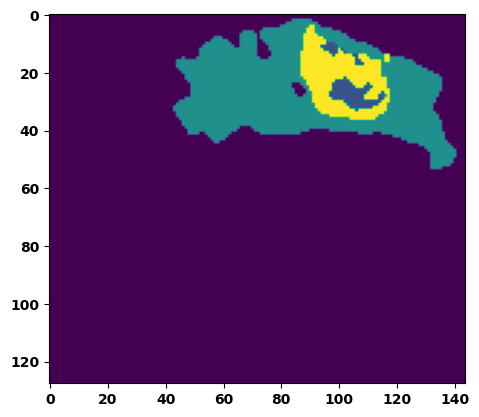

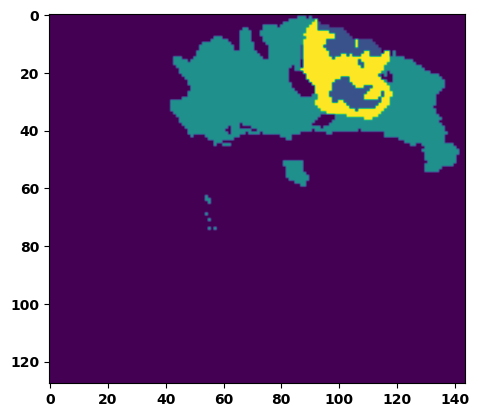

  6%|▌         | 2/36 [00:02<00:44,  1.31s/it]

Batch_id:  2 Test loss:  0.21589307487010956
Batch_id:  2 Test IoU:  tensor(0.6814, device='cuda:0')
Batch_id:  2 Test Mean Dice Score:  tensor(0.9641, device='cuda:0')
Batch_id:  2 Test Non-tumor Dice Score:  tensor(0.9590, device='cuda:0')
Batch_id:  2 Test NCR/NET Dice Score:  tensor(0.9918, device='cuda:0')
Batch_id:  2 Test ED Dice Score:  tensor(0.9553, device='cuda:0')
Batch_id:  2 Test ET Dice Score:  tensor(0.9861, device='cuda:0')


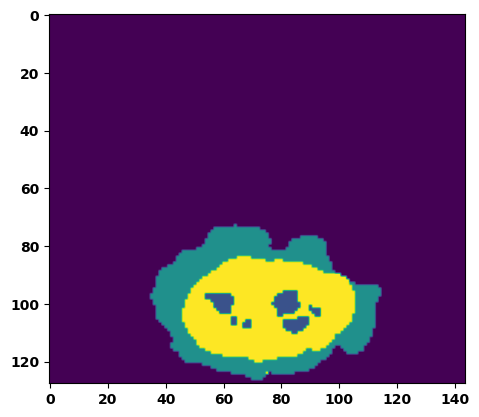

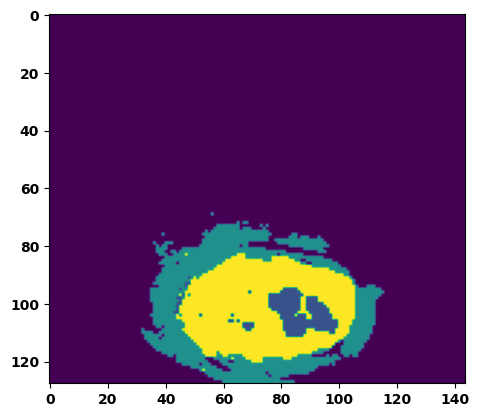

  8%|▊         | 3/36 [00:03<00:40,  1.24s/it]

Batch_id:  3 Test loss:  0.15502680838108063
Batch_id:  3 Test IoU:  tensor(0.7480, device='cuda:0')
Batch_id:  3 Test Mean Dice Score:  tensor(0.9814, device='cuda:0')
Batch_id:  3 Test Non-tumor Dice Score:  tensor(0.9872, device='cuda:0')
Batch_id:  3 Test NCR/NET Dice Score:  tensor(0.9863, device='cuda:0')
Batch_id:  3 Test ED Dice Score:  tensor(0.9877, device='cuda:0')
Batch_id:  3 Test ET Dice Score:  tensor(0.9832, device='cuda:0')


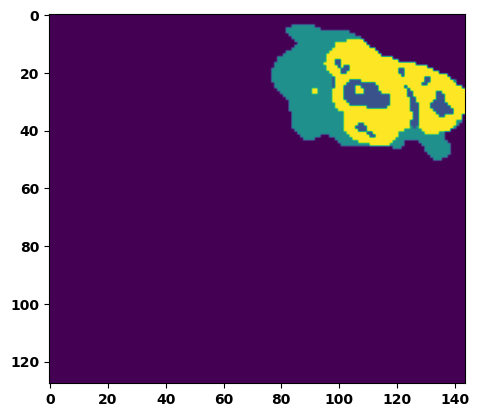

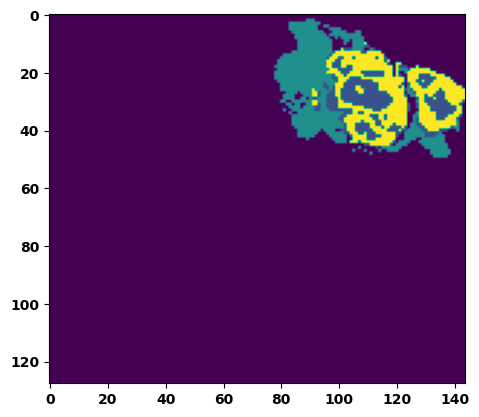

 11%|█         | 4/36 [00:05<00:39,  1.24s/it]

Batch_id:  4 Test loss:  0.32501304149627686
Batch_id:  4 Test IoU:  tensor(0.6012, device='cuda:0')
Batch_id:  4 Test Mean Dice Score:  tensor(0.9586, device='cuda:0')
Batch_id:  4 Test Non-tumor Dice Score:  tensor(0.9434, device='cuda:0')
Batch_id:  4 Test NCR/NET Dice Score:  tensor(0.9962, device='cuda:0')
Batch_id:  4 Test ED Dice Score:  tensor(0.9391, device='cuda:0')
Batch_id:  4 Test ET Dice Score:  tensor(0.9970, device='cuda:0')


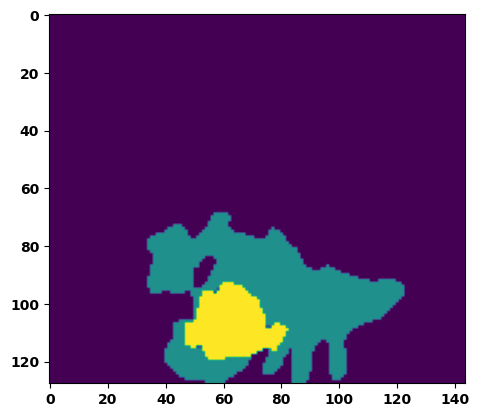

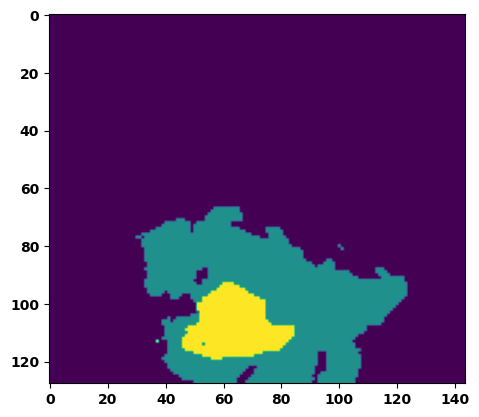

 14%|█▍        | 5/36 [00:06<00:37,  1.20s/it]

Batch_id:  5 Test loss:  0.1508561372756958
Batch_id:  5 Test IoU:  tensor(0.7764, device='cuda:0')
Batch_id:  5 Test Mean Dice Score:  tensor(0.9811, device='cuda:0')
Batch_id:  5 Test Non-tumor Dice Score:  tensor(0.9817, device='cuda:0')
Batch_id:  5 Test NCR/NET Dice Score:  tensor(0.9942, device='cuda:0')
Batch_id:  5 Test ED Dice Score:  tensor(0.9742, device='cuda:0')
Batch_id:  5 Test ET Dice Score:  tensor(0.9933, device='cuda:0')


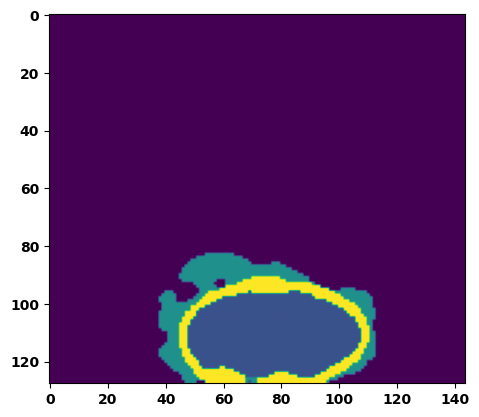

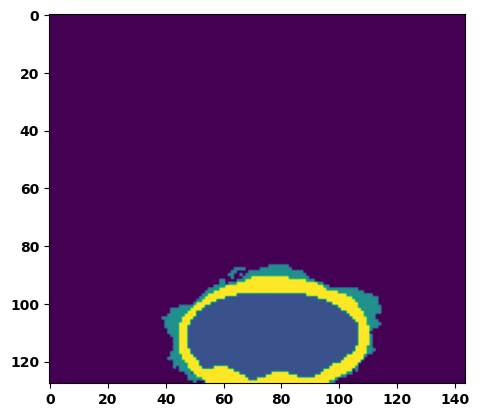

 17%|█▋        | 6/36 [00:07<00:35,  1.18s/it]

Batch_id:  6 Test loss:  0.057564958930015564
Batch_id:  6 Test IoU:  tensor(0.9012, device='cuda:0')
Batch_id:  6 Test Mean Dice Score:  tensor(0.9850, device='cuda:0')
Batch_id:  6 Test Non-tumor Dice Score:  tensor(0.9863, device='cuda:0')
Batch_id:  6 Test NCR/NET Dice Score:  tensor(0.9936, device='cuda:0')
Batch_id:  6 Test ED Dice Score:  tensor(0.9814, device='cuda:0')
Batch_id:  6 Test ET Dice Score:  tensor(0.9938, device='cuda:0')


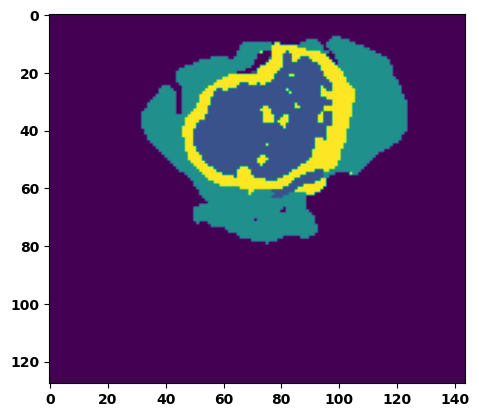

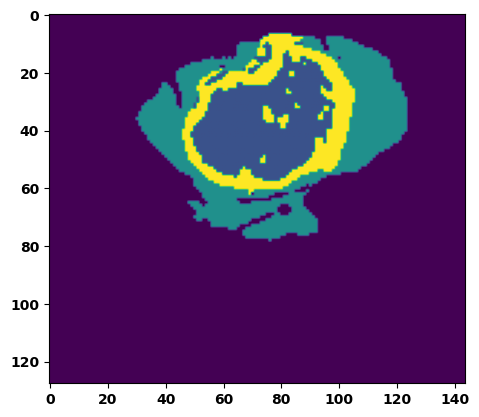

 19%|█▉        | 7/36 [00:08<00:34,  1.19s/it]

Batch_id:  7 Test loss:  0.2911916971206665
Batch_id:  7 Test IoU:  tensor(0.6046, device='cuda:0')
Batch_id:  7 Test Mean Dice Score:  tensor(0.9652, device='cuda:0')
Batch_id:  7 Test Non-tumor Dice Score:  tensor(0.9790, device='cuda:0')
Batch_id:  7 Test NCR/NET Dice Score:  tensor(0.9668, device='cuda:0')
Batch_id:  7 Test ED Dice Score:  tensor(0.9689, device='cuda:0')
Batch_id:  7 Test ET Dice Score:  tensor(0.9810, device='cuda:0')


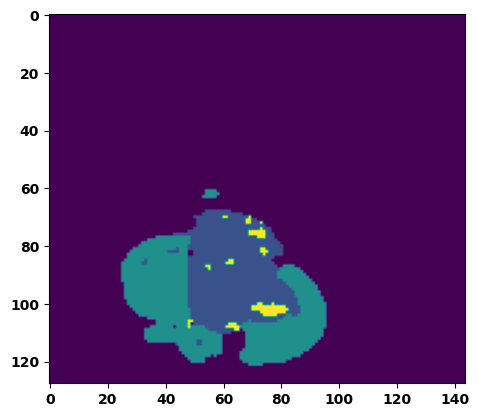

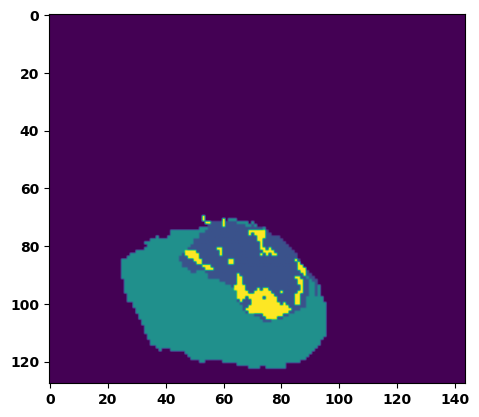

 22%|██▏       | 8/36 [00:09<00:34,  1.22s/it]

Batch_id:  8 Test loss:  0.39971792697906494
Batch_id:  8 Test IoU:  tensor(0.5066, device='cuda:0')
Batch_id:  8 Test Mean Dice Score:  tensor(0.9754, device='cuda:0')
Batch_id:  8 Test Non-tumor Dice Score:  tensor(0.9741, device='cuda:0')
Batch_id:  8 Test NCR/NET Dice Score:  tensor(0.9939, device='cuda:0')
Batch_id:  8 Test ED Dice Score:  tensor(0.9646, device='cuda:0')
Batch_id:  8 Test ET Dice Score:  tensor(0.9937, device='cuda:0')


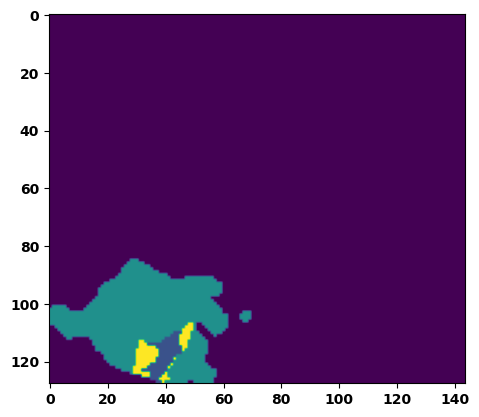

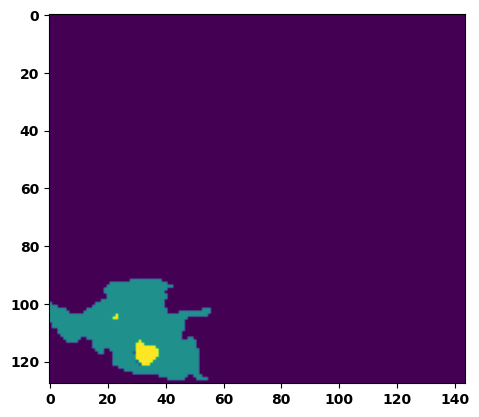

 25%|██▌       | 9/36 [00:11<00:33,  1.23s/it]

Batch_id:  9 Test loss:  0.15568912029266357
Batch_id:  9 Test IoU:  tensor(0.7608, device='cuda:0')
Batch_id:  9 Test Mean Dice Score:  tensor(0.9824, device='cuda:0')
Batch_id:  9 Test Non-tumor Dice Score:  tensor(0.9855, device='cuda:0')
Batch_id:  9 Test NCR/NET Dice Score:  tensor(0.9929, device='cuda:0')
Batch_id:  9 Test ED Dice Score:  tensor(0.9809, device='cuda:0')
Batch_id:  9 Test ET Dice Score:  tensor(0.9880, device='cuda:0')


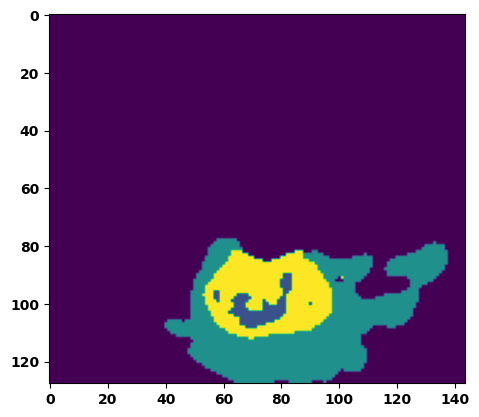

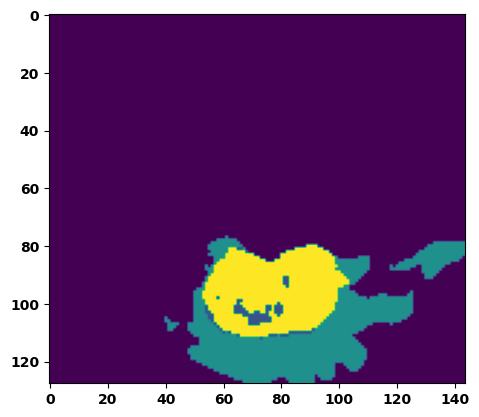

 28%|██▊       | 10/36 [00:12<00:31,  1.22s/it]

Batch_id:  10 Test loss:  0.08423496782779694
Batch_id:  10 Test IoU:  tensor(0.8567, device='cuda:0')
Batch_id:  10 Test Mean Dice Score:  tensor(0.9746, device='cuda:0')
Batch_id:  10 Test Non-tumor Dice Score:  tensor(0.9679, device='cuda:0')
Batch_id:  10 Test NCR/NET Dice Score:  tensor(0.9957, device='cuda:0')
Batch_id:  10 Test ED Dice Score:  tensor(0.9674, device='cuda:0')
Batch_id:  10 Test ET Dice Score:  tensor(0.9930, device='cuda:0')


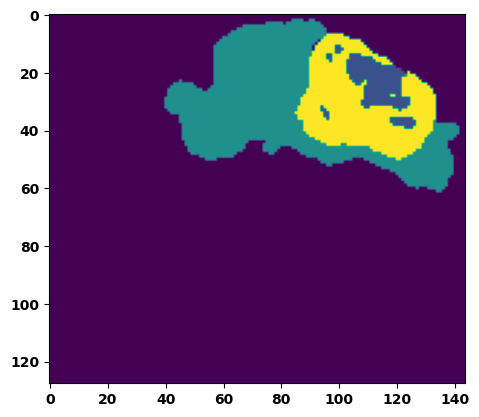

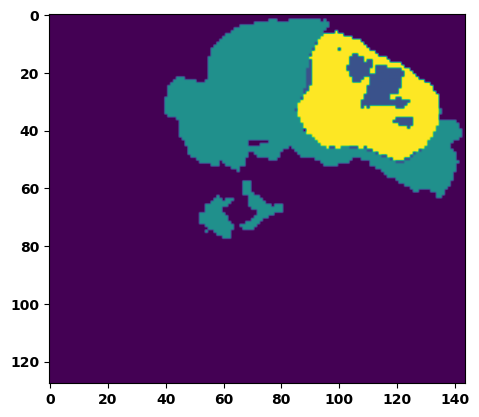

 31%|███       | 11/36 [00:13<00:30,  1.22s/it]

Batch_id:  11 Test loss:  0.13760852813720703
Batch_id:  11 Test IoU:  tensor(0.7702, device='cuda:0')
Batch_id:  11 Test Mean Dice Score:  tensor(0.9804, device='cuda:0')
Batch_id:  11 Test Non-tumor Dice Score:  tensor(0.9815, device='cuda:0')
Batch_id:  11 Test NCR/NET Dice Score:  tensor(0.9926, device='cuda:0')
Batch_id:  11 Test ED Dice Score:  tensor(0.9774, device='cuda:0')
Batch_id:  11 Test ET Dice Score:  tensor(0.9898, device='cuda:0')


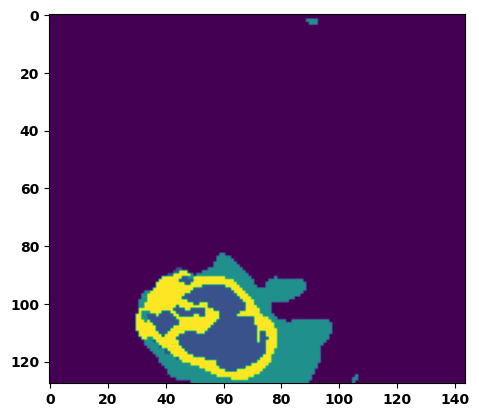

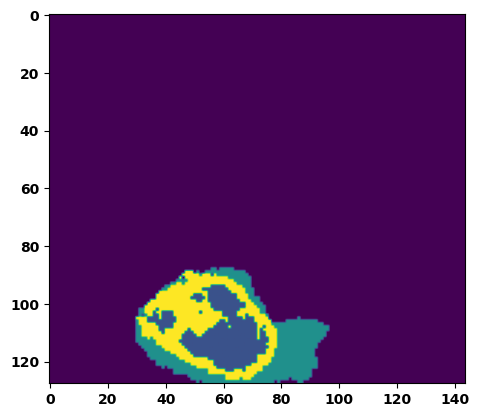

 33%|███▎      | 12/36 [00:14<00:29,  1.22s/it]

Batch_id:  12 Test loss:  0.07835462689399719
Batch_id:  12 Test IoU:  tensor(0.8632, device='cuda:0')
Batch_id:  12 Test Mean Dice Score:  tensor(0.9857, device='cuda:0')
Batch_id:  12 Test Non-tumor Dice Score:  tensor(0.9862, device='cuda:0')
Batch_id:  12 Test NCR/NET Dice Score:  tensor(0.9918, device='cuda:0')
Batch_id:  12 Test ED Dice Score:  tensor(0.9852, device='cuda:0')
Batch_id:  12 Test ET Dice Score:  tensor(0.9940, device='cuda:0')


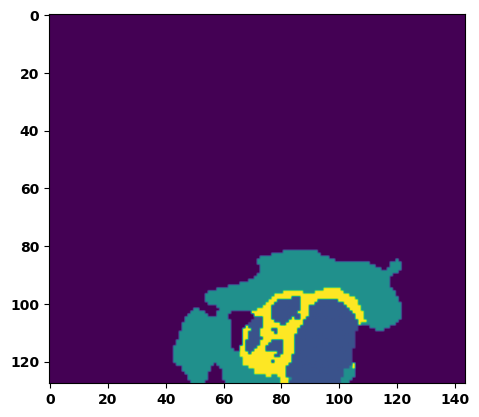

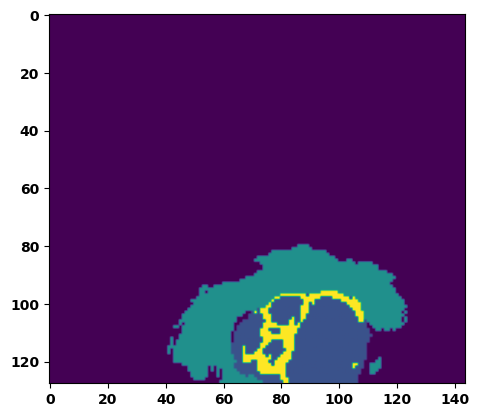

 36%|███▌      | 13/36 [00:16<00:29,  1.29s/it]

Batch_id:  13 Test loss:  0.17699019610881805
Batch_id:  13 Test IoU:  tensor(0.7384, device='cuda:0')
Batch_id:  13 Test Mean Dice Score:  tensor(0.9906, device='cuda:0')
Batch_id:  13 Test Non-tumor Dice Score:  tensor(0.9890, device='cuda:0')
Batch_id:  13 Test NCR/NET Dice Score:  tensor(0.9981, device='cuda:0')
Batch_id:  13 Test ED Dice Score:  tensor(0.9881, device='cuda:0')
Batch_id:  13 Test ET Dice Score:  tensor(0.9966, device='cuda:0')


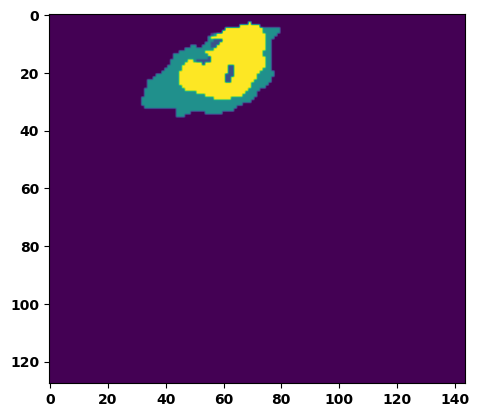

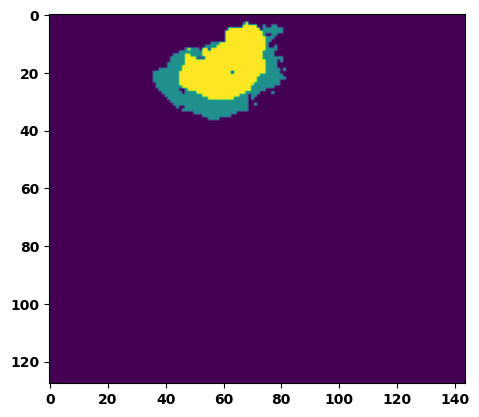

 39%|███▉      | 14/36 [00:17<00:27,  1.25s/it]

Batch_id:  14 Test loss:  0.10524727404117584
Batch_id:  14 Test IoU:  tensor(0.8176, device='cuda:0')
Batch_id:  14 Test Mean Dice Score:  tensor(0.9822, device='cuda:0')
Batch_id:  14 Test Non-tumor Dice Score:  tensor(0.9865, device='cuda:0')
Batch_id:  14 Test NCR/NET Dice Score:  tensor(0.9908, device='cuda:0')
Batch_id:  14 Test ED Dice Score:  tensor(0.9808, device='cuda:0')
Batch_id:  14 Test ET Dice Score:  tensor(0.9886, device='cuda:0')


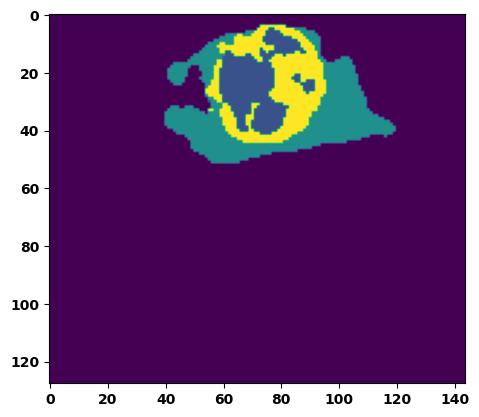

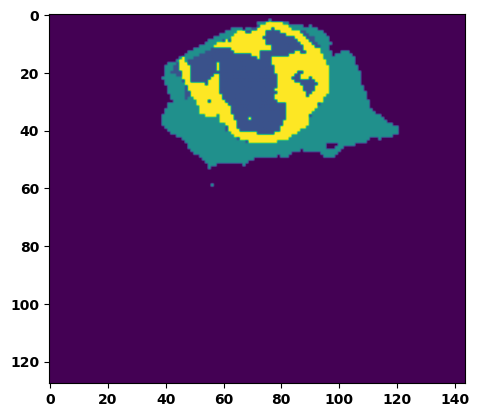

 42%|████▏     | 15/36 [00:18<00:25,  1.22s/it]

Batch_id:  15 Test loss:  0.19405564665794373
Batch_id:  15 Test IoU:  tensor(0.7124, device='cuda:0')
Batch_id:  15 Test Mean Dice Score:  tensor(0.9649, device='cuda:0')
Batch_id:  15 Test Non-tumor Dice Score:  tensor(0.9795, device='cuda:0')
Batch_id:  15 Test NCR/NET Dice Score:  tensor(0.9760, device='cuda:0')
Batch_id:  15 Test ED Dice Score:  tensor(0.9803, device='cuda:0')
Batch_id:  15 Test ET Dice Score:  tensor(0.9588, device='cuda:0')


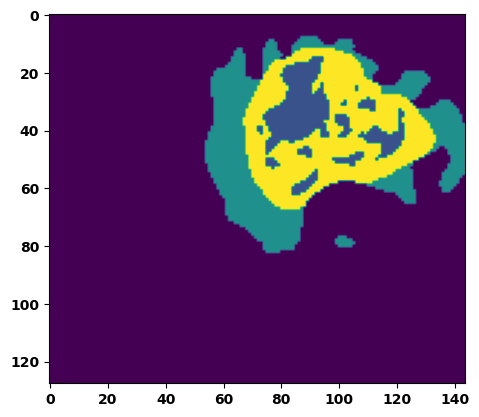

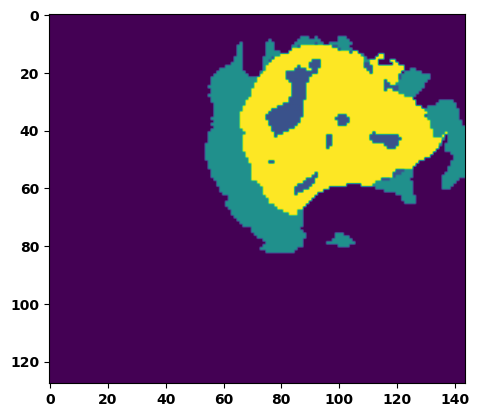

 44%|████▍     | 16/36 [00:19<00:24,  1.20s/it]

Batch_id:  16 Test loss:  0.08738662302494049
Batch_id:  16 Test IoU:  tensor(0.8462, device='cuda:0')
Batch_id:  16 Test Mean Dice Score:  tensor(0.9822, device='cuda:0')
Batch_id:  16 Test Non-tumor Dice Score:  tensor(0.9887, device='cuda:0')
Batch_id:  16 Test NCR/NET Dice Score:  tensor(0.9914, device='cuda:0')
Batch_id:  16 Test ED Dice Score:  tensor(0.9833, device='cuda:0')
Batch_id:  16 Test ET Dice Score:  tensor(0.9830, device='cuda:0')


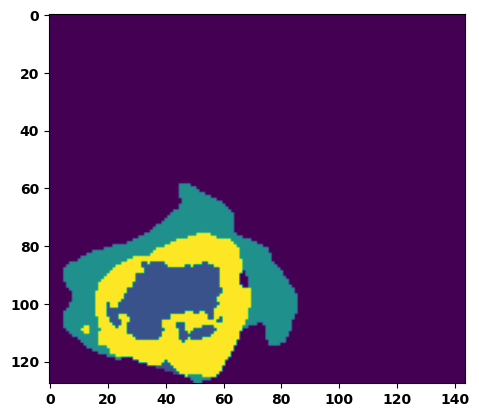

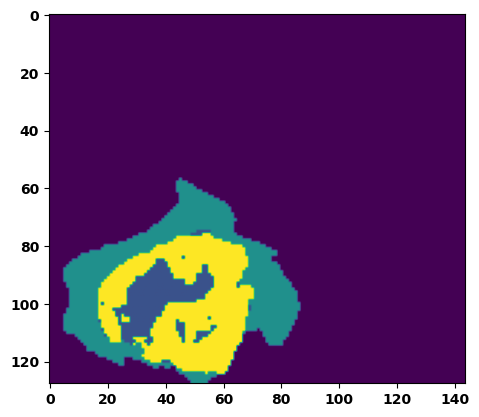

 47%|████▋     | 17/36 [00:20<00:22,  1.20s/it]

Batch_id:  17 Test loss:  0.08554726839065552
Batch_id:  17 Test IoU:  tensor(0.8547, device='cuda:0')
Batch_id:  17 Test Mean Dice Score:  tensor(0.9878, device='cuda:0')
Batch_id:  17 Test Non-tumor Dice Score:  tensor(0.9878, device='cuda:0')
Batch_id:  17 Test NCR/NET Dice Score:  tensor(0.9940, device='cuda:0')
Batch_id:  17 Test ED Dice Score:  tensor(0.9930, device='cuda:0')
Batch_id:  17 Test ET Dice Score:  tensor(0.9886, device='cuda:0')


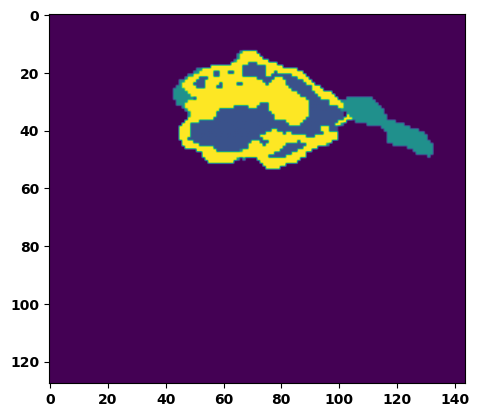

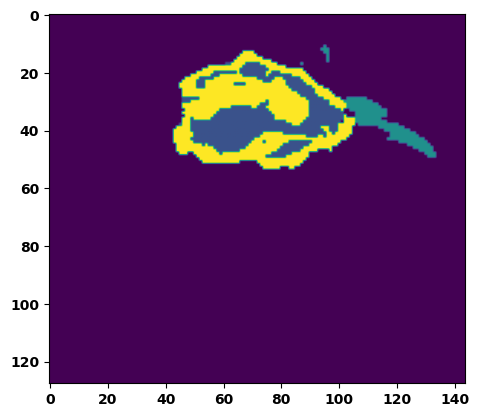

 50%|█████     | 18/36 [00:22<00:22,  1.22s/it]

Batch_id:  18 Test loss:  0.14165450632572174
Batch_id:  18 Test IoU:  tensor(0.7779, device='cuda:0')
Batch_id:  18 Test Mean Dice Score:  tensor(0.9881, device='cuda:0')
Batch_id:  18 Test Non-tumor Dice Score:  tensor(0.9922, device='cuda:0')
Batch_id:  18 Test NCR/NET Dice Score:  tensor(0.9932, device='cuda:0')
Batch_id:  18 Test ED Dice Score:  tensor(0.9913, device='cuda:0')
Batch_id:  18 Test ET Dice Score:  tensor(0.9875, device='cuda:0')


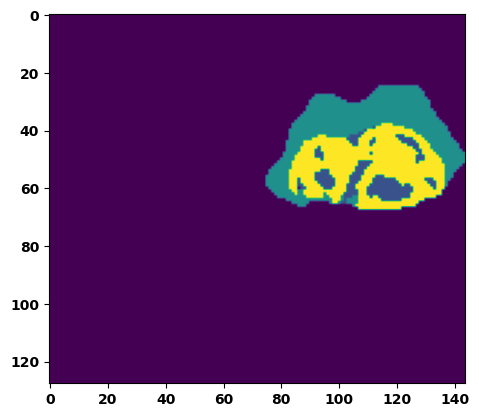

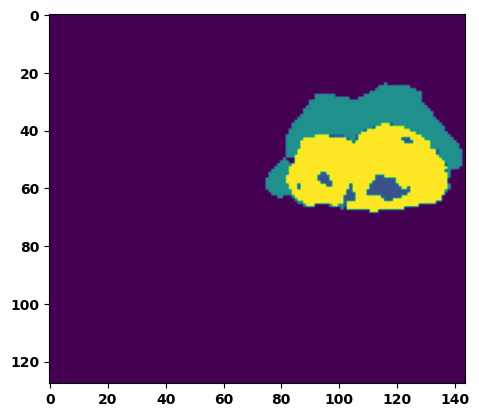

 53%|█████▎    | 19/36 [00:23<00:20,  1.22s/it]

Batch_id:  19 Test loss:  0.1363459825515747
Batch_id:  19 Test IoU:  tensor(0.7747, device='cuda:0')
Batch_id:  19 Test Mean Dice Score:  tensor(0.9807, device='cuda:0')
Batch_id:  19 Test Non-tumor Dice Score:  tensor(0.9854, device='cuda:0')
Batch_id:  19 Test NCR/NET Dice Score:  tensor(0.9942, device='cuda:0')
Batch_id:  19 Test ED Dice Score:  tensor(0.9786, device='cuda:0')
Batch_id:  19 Test ET Dice Score:  tensor(0.9840, device='cuda:0')


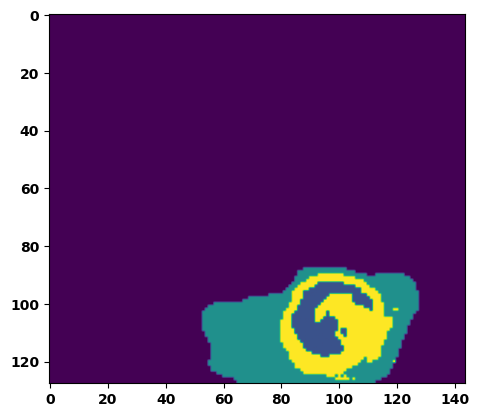

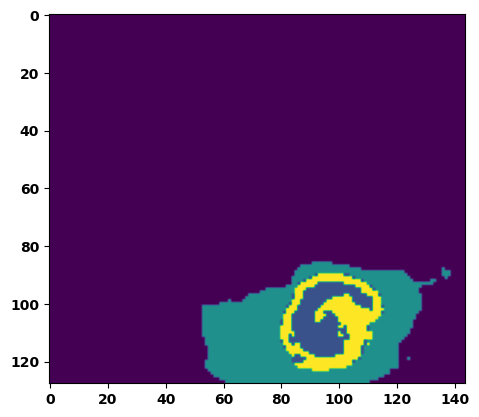

 56%|█████▌    | 20/36 [00:24<00:19,  1.23s/it]

Batch_id:  20 Test loss:  0.1295752078294754
Batch_id:  20 Test IoU:  tensor(0.7908, device='cuda:0')
Batch_id:  20 Test Mean Dice Score:  tensor(0.9893, device='cuda:0')
Batch_id:  20 Test Non-tumor Dice Score:  tensor(0.9892, device='cuda:0')
Batch_id:  20 Test NCR/NET Dice Score:  tensor(0.9974, device='cuda:0')
Batch_id:  20 Test ED Dice Score:  tensor(0.9881, device='cuda:0')
Batch_id:  20 Test ET Dice Score:  tensor(0.9933, device='cuda:0')


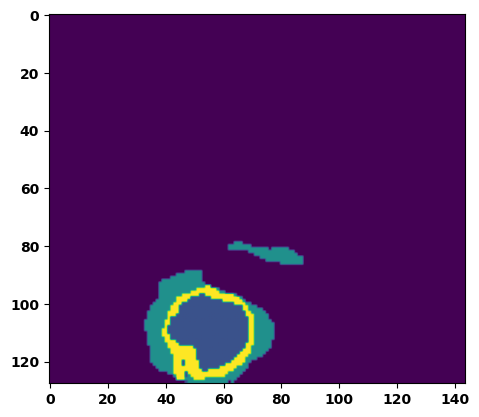

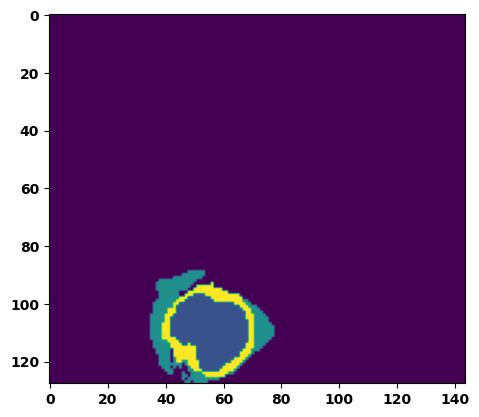

 58%|█████▊    | 21/36 [00:25<00:18,  1.23s/it]

Batch_id:  21 Test loss:  0.18335506319999695
Batch_id:  21 Test IoU:  tensor(0.7140, device='cuda:0')
Batch_id:  21 Test Mean Dice Score:  tensor(0.9457, device='cuda:0')
Batch_id:  21 Test Non-tumor Dice Score:  tensor(0.9663, device='cuda:0')
Batch_id:  21 Test NCR/NET Dice Score:  tensor(0.9512, device='cuda:0')
Batch_id:  21 Test ED Dice Score:  tensor(0.9339, device='cuda:0')
Batch_id:  21 Test ET Dice Score:  tensor(0.9857, device='cuda:0')


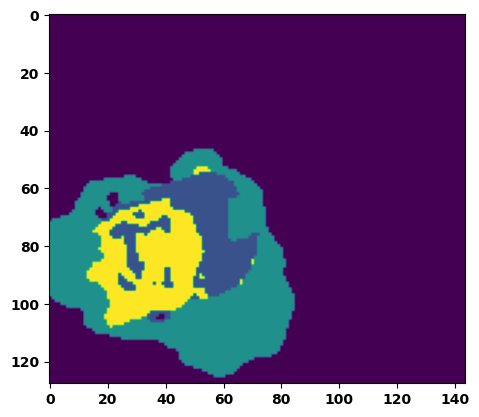

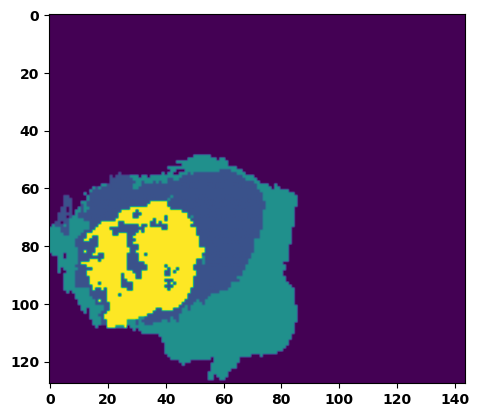

 61%|██████    | 22/36 [00:27<00:17,  1.24s/it]

Batch_id:  22 Test loss:  0.20145876705646515
Batch_id:  22 Test IoU:  tensor(0.7445, device='cuda:0')
Batch_id:  22 Test Mean Dice Score:  tensor(0.9833, device='cuda:0')
Batch_id:  22 Test Non-tumor Dice Score:  tensor(0.9786, device='cuda:0')
Batch_id:  22 Test NCR/NET Dice Score:  tensor(0.9982, device='cuda:0')
Batch_id:  22 Test ED Dice Score:  tensor(0.9772, device='cuda:0')
Batch_id:  22 Test ET Dice Score:  tensor(0.9959, device='cuda:0')


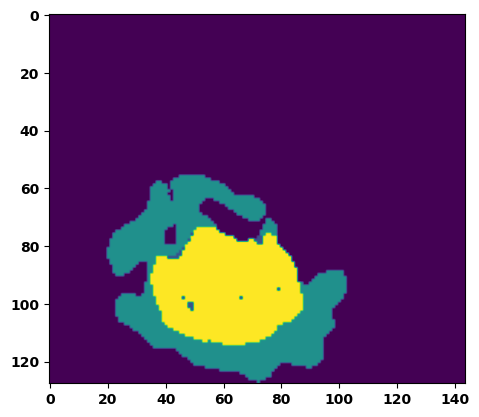

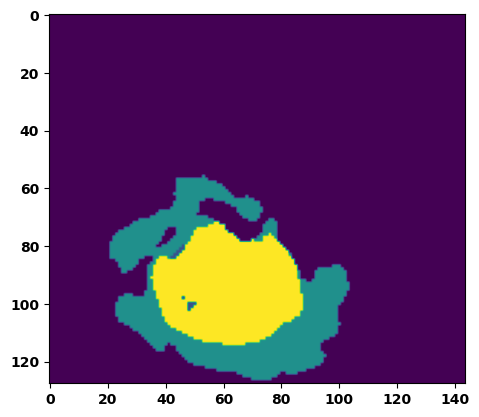

 64%|██████▍   | 23/36 [00:28<00:15,  1.23s/it]

Batch_id:  23 Test loss:  0.0927746444940567
Batch_id:  23 Test IoU:  tensor(0.8426, device='cuda:0')
Batch_id:  23 Test Mean Dice Score:  tensor(0.9897, device='cuda:0')
Batch_id:  23 Test Non-tumor Dice Score:  tensor(0.9920, device='cuda:0')
Batch_id:  23 Test NCR/NET Dice Score:  tensor(0.9940, device='cuda:0')
Batch_id:  23 Test ED Dice Score:  tensor(0.9889, device='cuda:0')
Batch_id:  23 Test ET Dice Score:  tensor(0.9943, device='cuda:0')


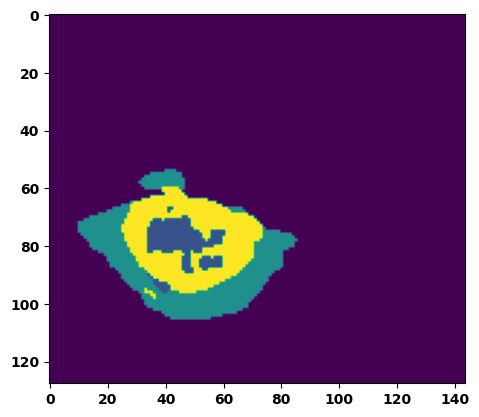

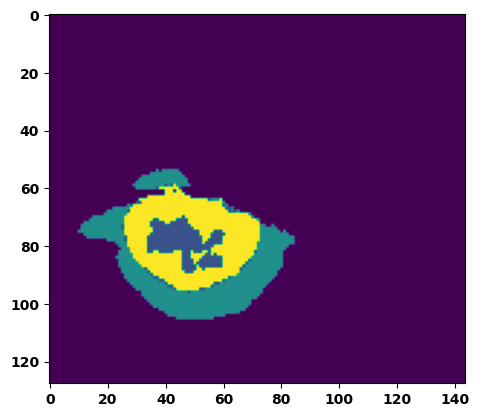

 67%|██████▋   | 24/36 [00:29<00:14,  1.21s/it]

Batch_id:  24 Test loss:  0.12009011209011078
Batch_id:  24 Test IoU:  tensor(0.7998, device='cuda:0')
Batch_id:  24 Test Mean Dice Score:  tensor(0.9630, device='cuda:0')
Batch_id:  24 Test Non-tumor Dice Score:  tensor(0.9522, device='cuda:0')
Batch_id:  24 Test NCR/NET Dice Score:  tensor(0.9934, device='cuda:0')
Batch_id:  24 Test ED Dice Score:  tensor(0.9612, device='cuda:0')
Batch_id:  24 Test ET Dice Score:  tensor(0.9821, device='cuda:0')


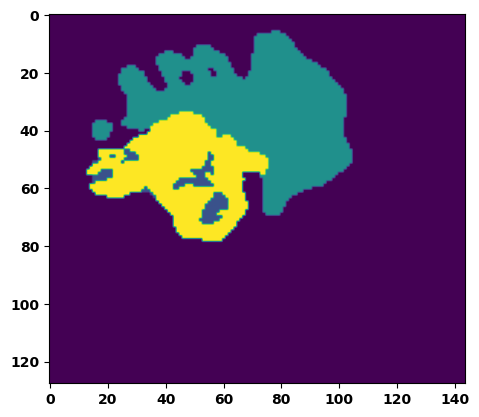

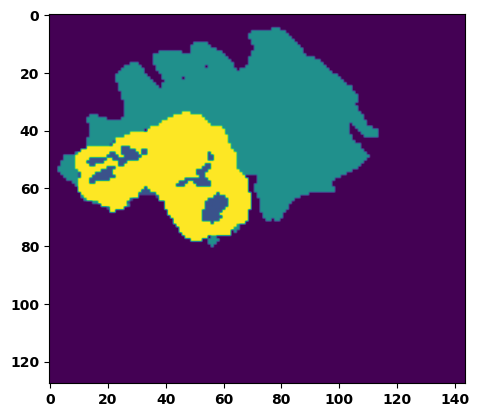

 69%|██████▉   | 25/36 [00:30<00:13,  1.22s/it]

Batch_id:  25 Test loss:  0.0526205450296402
Batch_id:  25 Test IoU:  tensor(0.9079, device='cuda:0')
Batch_id:  25 Test Mean Dice Score:  tensor(0.9876, device='cuda:0')
Batch_id:  25 Test Non-tumor Dice Score:  tensor(0.9868, device='cuda:0')
Batch_id:  25 Test NCR/NET Dice Score:  tensor(0.9947, device='cuda:0')
Batch_id:  25 Test ED Dice Score:  tensor(0.9886, device='cuda:0')
Batch_id:  25 Test ET Dice Score:  tensor(0.9929, device='cuda:0')


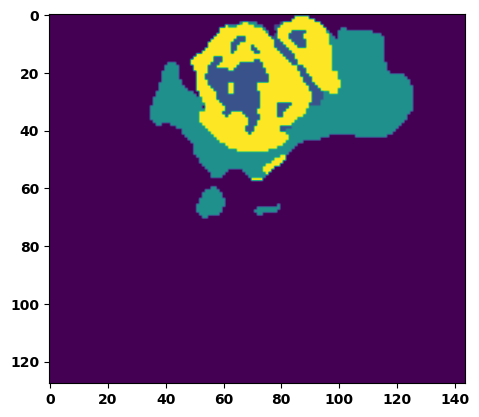

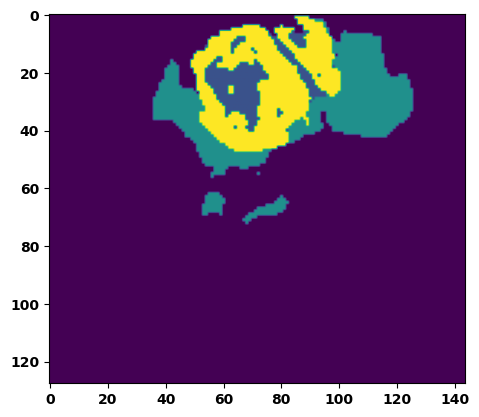

 72%|███████▏  | 26/36 [00:31<00:12,  1.24s/it]

Batch_id:  26 Test loss:  0.19573575258255005
Batch_id:  26 Test IoU:  tensor(0.7380, device='cuda:0')
Batch_id:  26 Test Mean Dice Score:  tensor(0.9956, device='cuda:0')
Batch_id:  26 Test Non-tumor Dice Score:  tensor(0.9954, device='cuda:0')
Batch_id:  26 Test NCR/NET Dice Score:  tensor(0.9990, device='cuda:0')
Batch_id:  26 Test ED Dice Score:  tensor(0.9943, device='cuda:0')
Batch_id:  26 Test ET Dice Score:  tensor(0.9980, device='cuda:0')


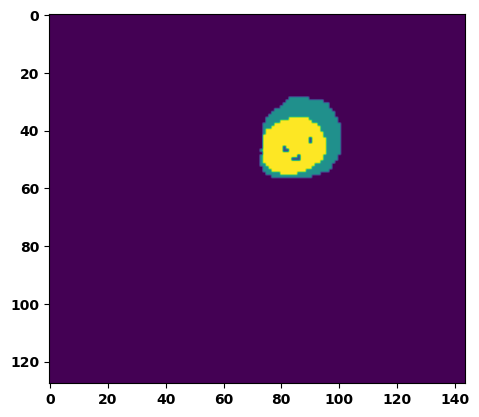

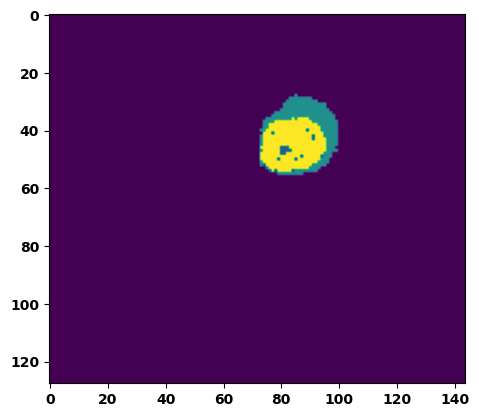

 75%|███████▌  | 27/36 [00:33<00:11,  1.26s/it]

Batch_id:  27 Test loss:  0.3190544843673706
Batch_id:  27 Test IoU:  tensor(0.5984, device='cuda:0')
Batch_id:  27 Test Mean Dice Score:  tensor(0.9748, device='cuda:0')
Batch_id:  27 Test Non-tumor Dice Score:  tensor(0.9865, device='cuda:0')
Batch_id:  27 Test NCR/NET Dice Score:  tensor(0.9767, device='cuda:0')
Batch_id:  27 Test ED Dice Score:  tensor(0.9701, device='cuda:0')
Batch_id:  27 Test ET Dice Score:  tensor(0.9911, device='cuda:0')


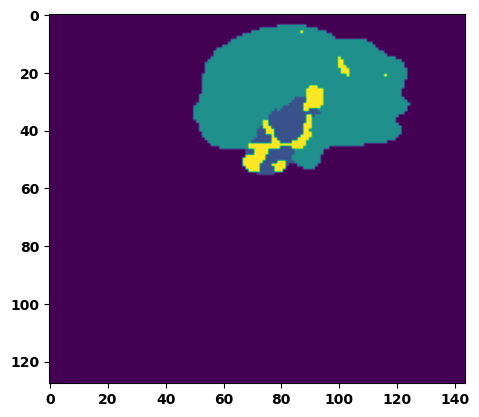

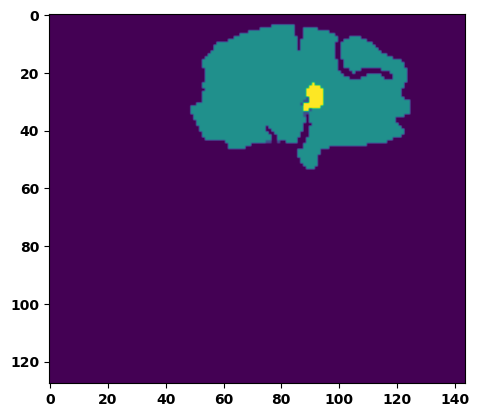

 78%|███████▊  | 28/36 [00:34<00:10,  1.25s/it]

Batch_id:  28 Test loss:  0.23518233001232147
Batch_id:  28 Test IoU:  tensor(0.6818, device='cuda:0')
Batch_id:  28 Test Mean Dice Score:  tensor(0.9708, device='cuda:0')
Batch_id:  28 Test Non-tumor Dice Score:  tensor(0.9846, device='cuda:0')
Batch_id:  28 Test NCR/NET Dice Score:  tensor(0.9719, device='cuda:0')
Batch_id:  28 Test ED Dice Score:  tensor(0.9577, device='cuda:0')
Batch_id:  28 Test ET Dice Score:  tensor(0.9983, device='cuda:0')


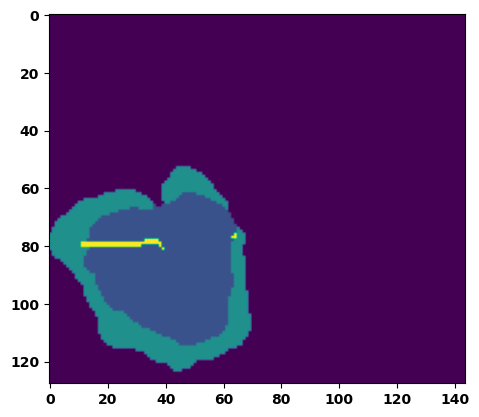

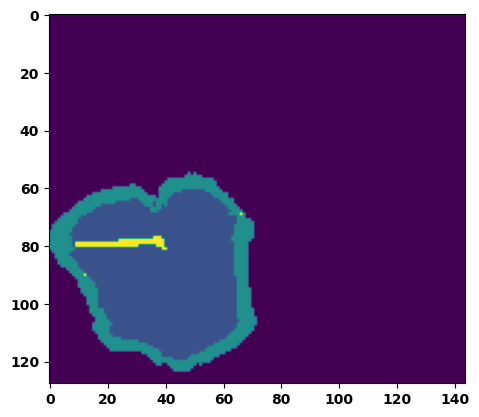

 81%|████████  | 29/36 [00:35<00:08,  1.24s/it]

Batch_id:  29 Test loss:  0.7190443277359009
Batch_id:  29 Test IoU:  tensor(0.2466, device='cuda:0')
Batch_id:  29 Test Mean Dice Score:  tensor(0.9212, device='cuda:0')
Batch_id:  29 Test Non-tumor Dice Score:  tensor(0.8936, device='cuda:0')
Batch_id:  29 Test NCR/NET Dice Score:  tensor(0.9723, device='cuda:0')
Batch_id:  29 Test ED Dice Score:  tensor(0.9085, device='cuda:0')
Batch_id:  29 Test ET Dice Score:  tensor(0.9891, device='cuda:0')


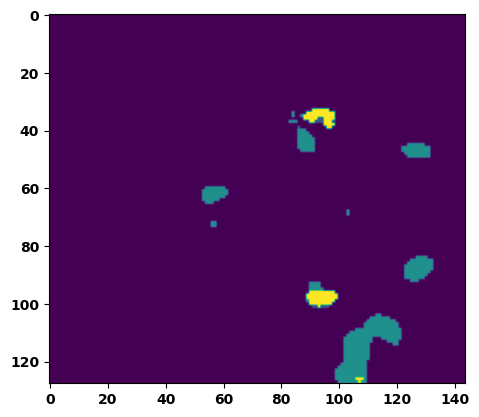

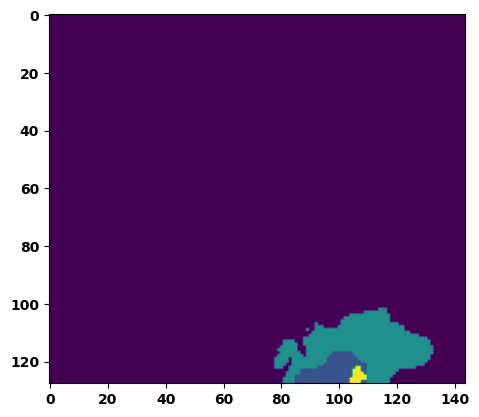

 83%|████████▎ | 30/36 [00:36<00:07,  1.21s/it]

Batch_id:  30 Test loss:  0.09587174654006958
Batch_id:  30 Test IoU:  tensor(0.8338, device='cuda:0')
Batch_id:  30 Test Mean Dice Score:  tensor(0.9833, device='cuda:0')
Batch_id:  30 Test Non-tumor Dice Score:  tensor(0.9879, device='cuda:0')
Batch_id:  30 Test NCR/NET Dice Score:  tensor(0.9898, device='cuda:0')
Batch_id:  30 Test ED Dice Score:  tensor(0.9816, device='cuda:0')
Batch_id:  30 Test ET Dice Score:  tensor(0.9905, device='cuda:0')


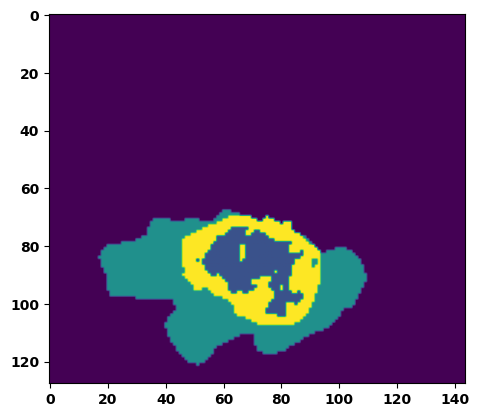

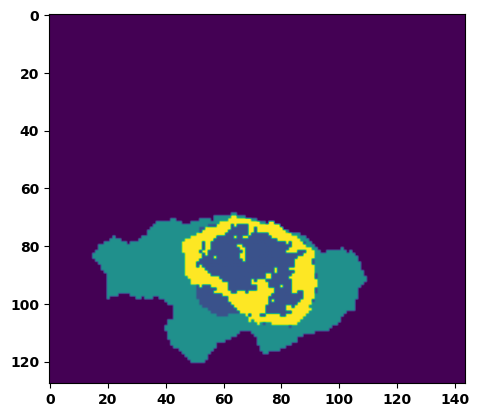

 86%|████████▌ | 31/36 [00:38<00:06,  1.23s/it]

Batch_id:  31 Test loss:  0.0911610871553421
Batch_id:  31 Test IoU:  tensor(0.8603, device='cuda:0')
Batch_id:  31 Test Mean Dice Score:  tensor(0.9921, device='cuda:0')
Batch_id:  31 Test Non-tumor Dice Score:  tensor(0.9889, device='cuda:0')
Batch_id:  31 Test NCR/NET Dice Score:  tensor(0.9997, device='cuda:0')
Batch_id:  31 Test ED Dice Score:  tensor(0.9892, device='cuda:0')
Batch_id:  31 Test ET Dice Score:  tensor(0.9986, device='cuda:0')


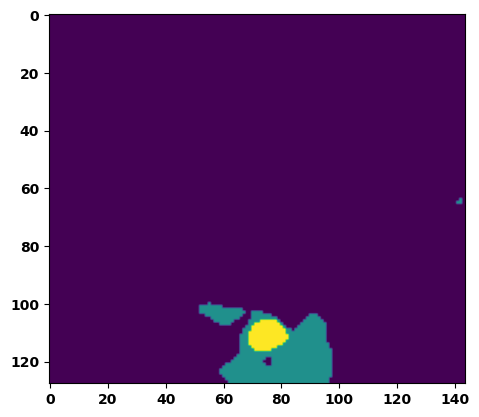

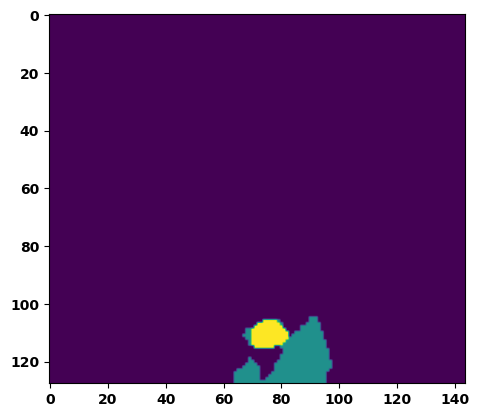

 89%|████████▉ | 32/36 [00:39<00:04,  1.25s/it]

Batch_id:  32 Test loss:  0.06283818185329437
Batch_id:  32 Test IoU:  tensor(0.8887, device='cuda:0')
Batch_id:  32 Test Mean Dice Score:  tensor(0.9922, device='cuda:0')
Batch_id:  32 Test Non-tumor Dice Score:  tensor(0.9928, device='cuda:0')
Batch_id:  32 Test NCR/NET Dice Score:  tensor(0.9978, device='cuda:0')
Batch_id:  32 Test ED Dice Score:  tensor(0.9909, device='cuda:0')
Batch_id:  32 Test ET Dice Score:  tensor(0.9951, device='cuda:0')


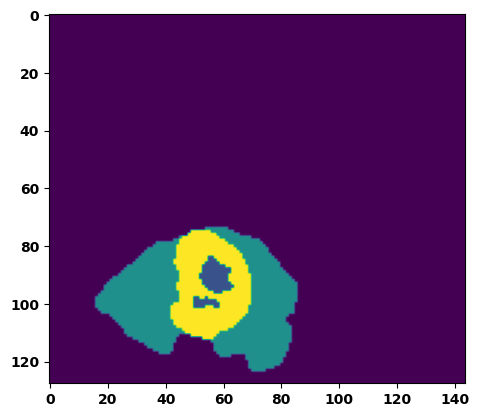

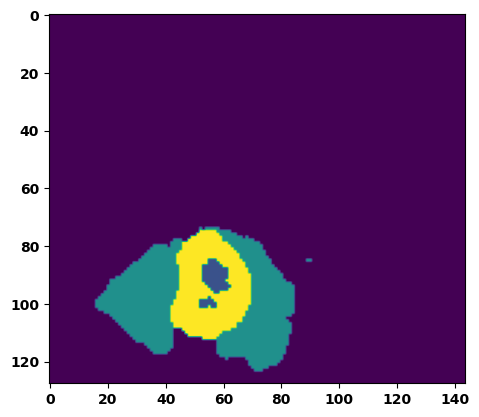

 92%|█████████▏| 33/36 [00:40<00:03,  1.25s/it]

Batch_id:  33 Test loss:  0.08501780033111572
Batch_id:  33 Test IoU:  tensor(0.8946, device='cuda:0')
Batch_id:  33 Test Mean Dice Score:  tensor(0.9957, device='cuda:0')
Batch_id:  33 Test Non-tumor Dice Score:  tensor(0.9945, device='cuda:0')
Batch_id:  33 Test NCR/NET Dice Score:  tensor(0.9999, device='cuda:0')
Batch_id:  33 Test ED Dice Score:  tensor(0.9937, device='cuda:0')
Batch_id:  33 Test ET Dice Score:  tensor(0.9991, device='cuda:0')


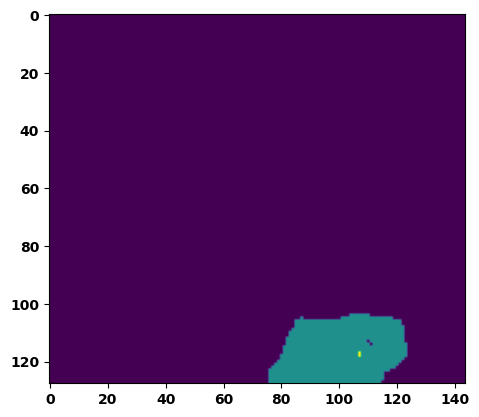

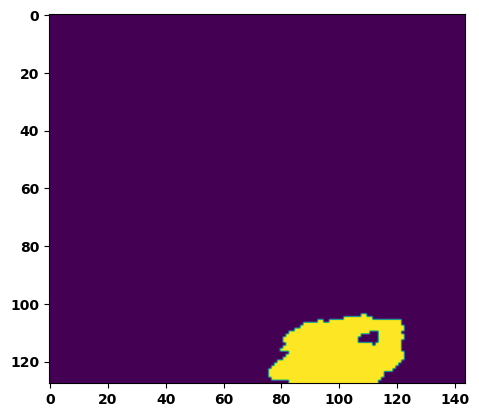

 94%|█████████▍| 34/36 [00:41<00:02,  1.24s/it]

Batch_id:  34 Test loss:  0.21020612120628357
Batch_id:  34 Test IoU:  tensor(0.6848, device='cuda:0')
Batch_id:  34 Test Mean Dice Score:  tensor(0.9677, device='cuda:0')
Batch_id:  34 Test Non-tumor Dice Score:  tensor(0.9832, device='cuda:0')
Batch_id:  34 Test NCR/NET Dice Score:  tensor(0.9739, device='cuda:0')
Batch_id:  34 Test ED Dice Score:  tensor(0.9861, device='cuda:0')
Batch_id:  34 Test ET Dice Score:  tensor(0.9600, device='cuda:0')


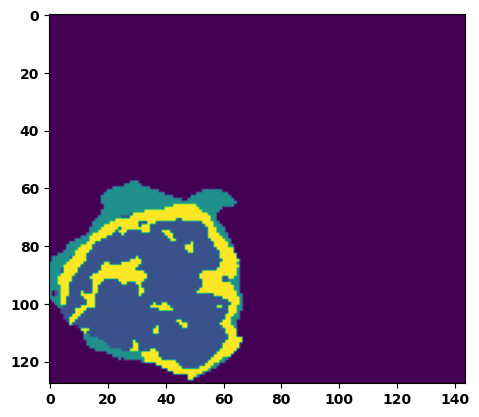

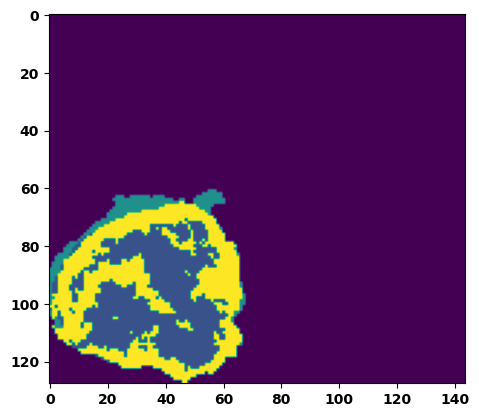

 97%|█████████▋| 35/36 [00:43<00:01,  1.24s/it]

Batch_id:  35 Test loss:  0.24615508317947388
Batch_id:  35 Test IoU:  tensor(0.6827, device='cuda:0')
Batch_id:  35 Test Mean Dice Score:  tensor(0.9882, device='cuda:0')
Batch_id:  35 Test Non-tumor Dice Score:  tensor(0.9859, device='cuda:0')
Batch_id:  35 Test NCR/NET Dice Score:  tensor(0.9991, device='cuda:0')
Batch_id:  35 Test ED Dice Score:  tensor(0.9833, device='cuda:0')
Batch_id:  35 Test ET Dice Score:  tensor(0.9962, device='cuda:0')


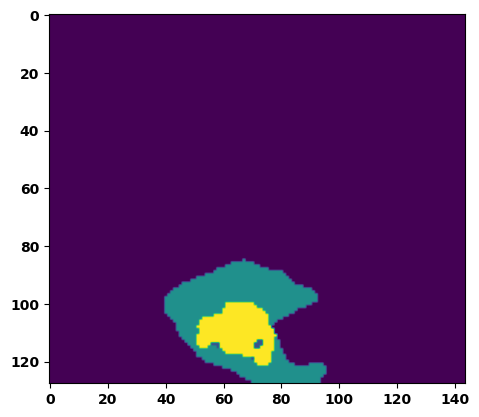

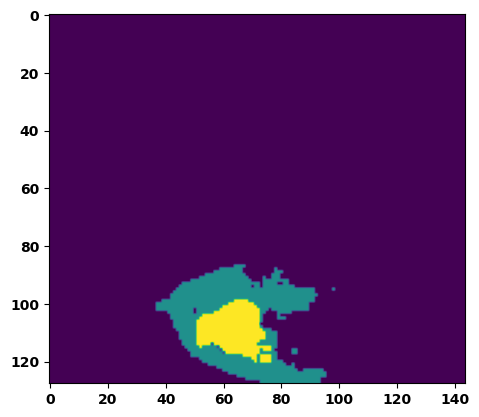

100%|██████████| 36/36 [00:44<00:00,  1.23s/it]

Avg IoU:  tensor(0.7532)
Avg Loss:  0.17384297607673538
Avg Dice Scores:  tensor(0.9784)
Non-Tumor Dice Scores:  tensor(0.9798)
NCR/NET Dice Scores:  tensor(0.9898)
ED Dice Scores:  tensor(0.9761)
ET Dice Scores:  tensor(0.9897)


In [38]:
"""
yellow - label 4
dark blue - label 1 
green - label 2 

purple - label 0
"""

main(0.75)